In [344]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.options.mode.chained_assignment = None  # default='warn'

In [345]:
label_regular = 'Gasolina regular'
label_super = 'Gasolina superior'
label_diesel = 'Diesel'

# Exploración de Datos

In [346]:
dfToUse = "importacion"

def returnQuantRows(dfToUse):
    if (dfToUse == 'consumo'):
        return 269 
    return 257

toUse = returnQuantRows(dfToUse)

In [347]:
df = pd.read_excel(dfToUse+'.xlsx', engine='openpyxl')
df = df[['Fecha', label_super, label_regular, label_diesel]]

In [348]:
df = df[:toUse]
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [349]:
quant_vars = [label_super, label_regular, label_diesel]
df[quant_vars].astype(float).describe()

Gasolina superior  Gasolina regular        Diesel
count       2.570000e+02        257.000000  2.570000e+02
mean        4.735221e+05     361665.432077  8.496115e+05
std         1.543325e+05     201498.204778  2.724270e+05
min         1.702925e+05      81015.300000  2.297647e+05
25%         3.608070e+05     201213.100000  6.694625e+05
50%         4.459203e+05     291087.160000  8.168400e+05
75%         5.732206e+05     510830.000000  1.029101e+06
max         1.227174e+06     906104.050000  1.630636e+06

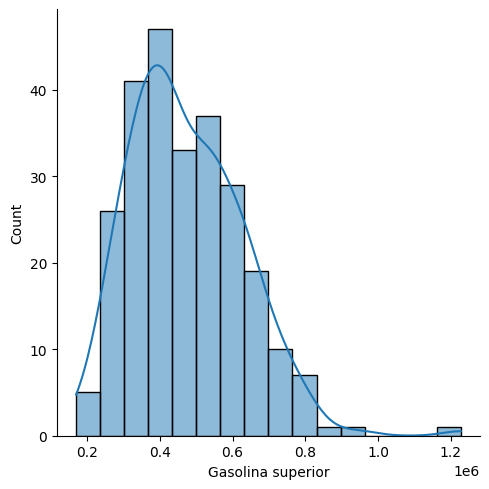

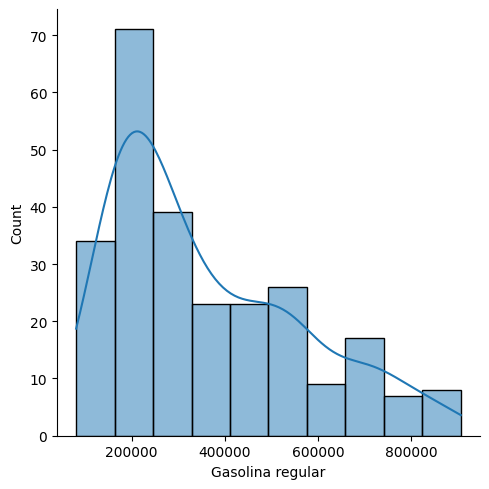

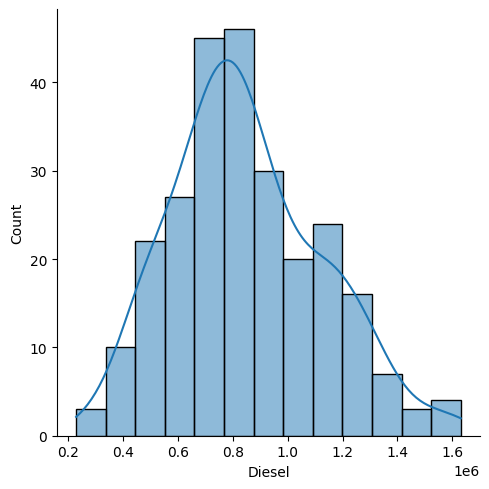

In [350]:
for var in quant_vars:
    data = df[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)
    # print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(data), 'Skewness:', stats.skew(data), '\n')


# Por año

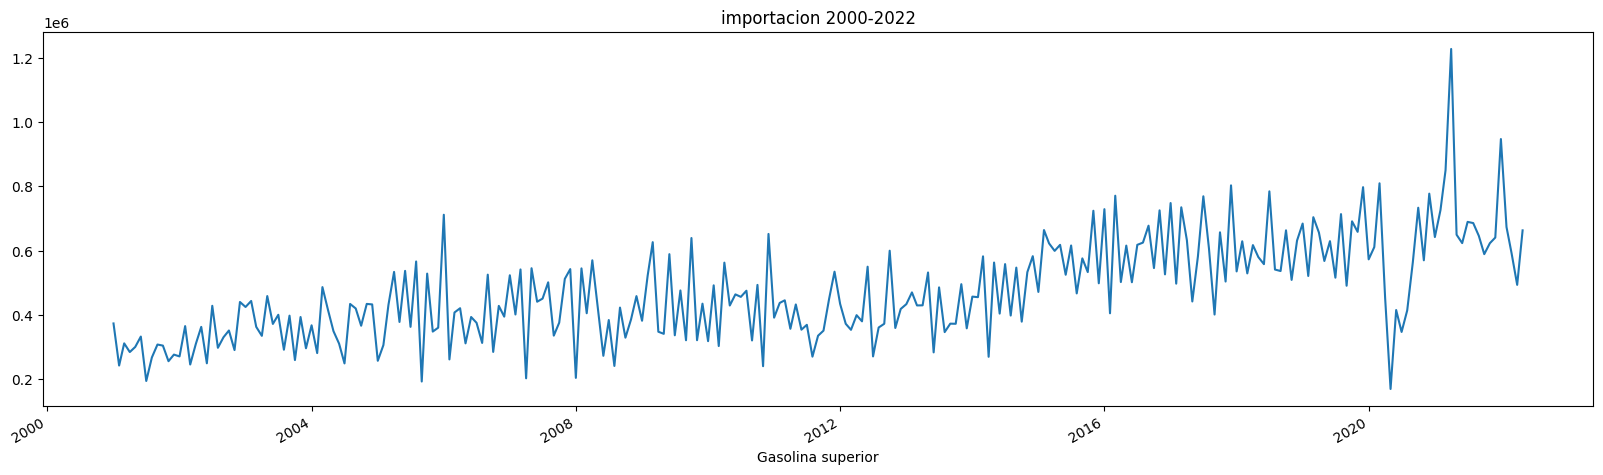

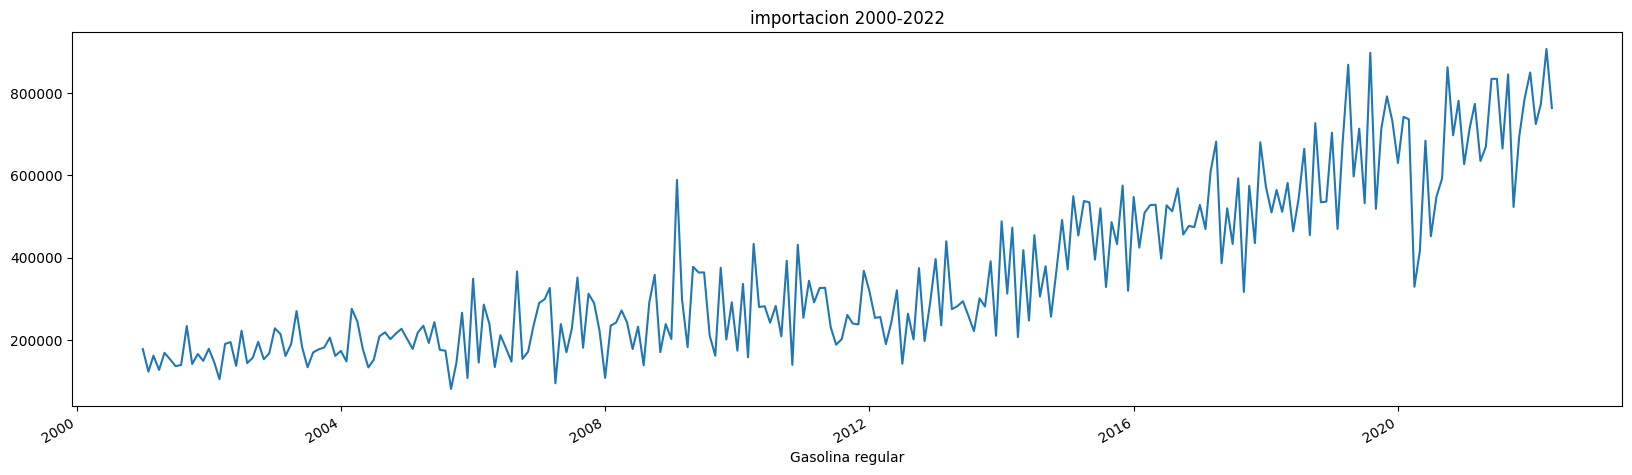

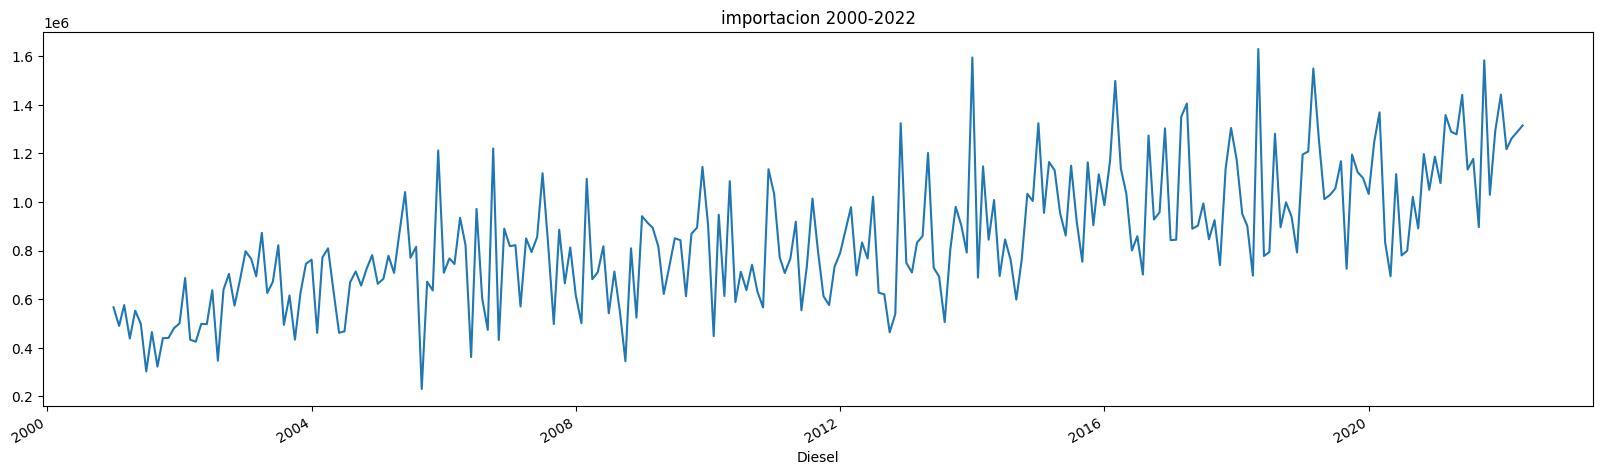

In [351]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = df['Fecha']
    y = df[gas]

    plt.title(dfToUse+" 2000-2022")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Por mes

In [352]:
dfPerMonth = df.groupby(df['Fecha'].dt.month)
dfPerMonth = dfPerMonth.sum()

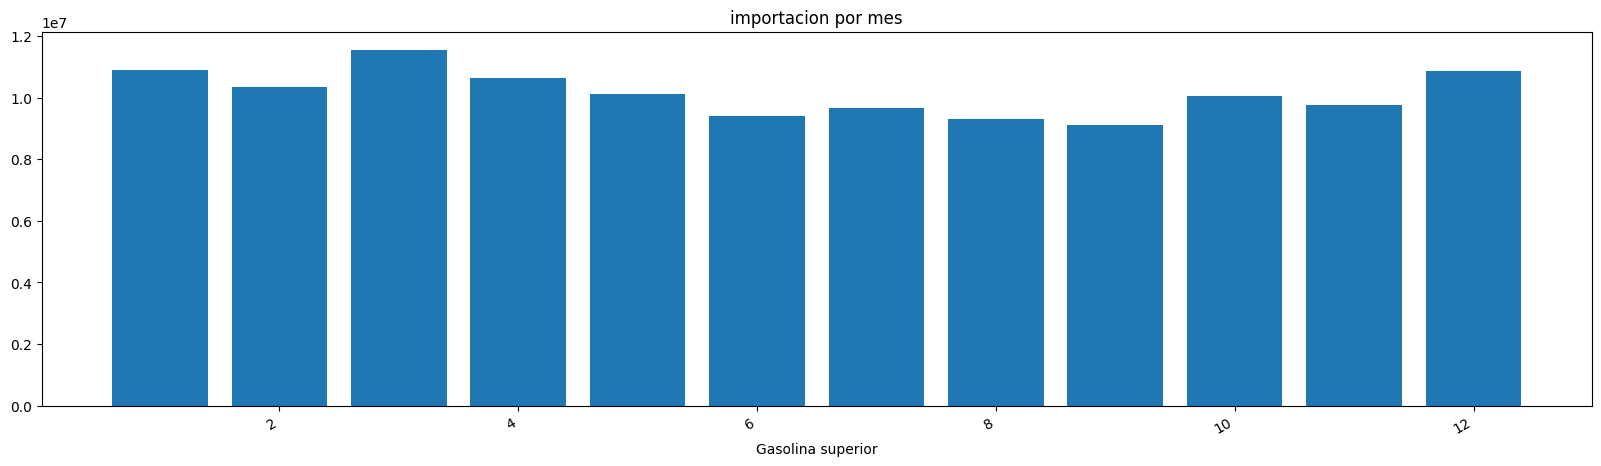

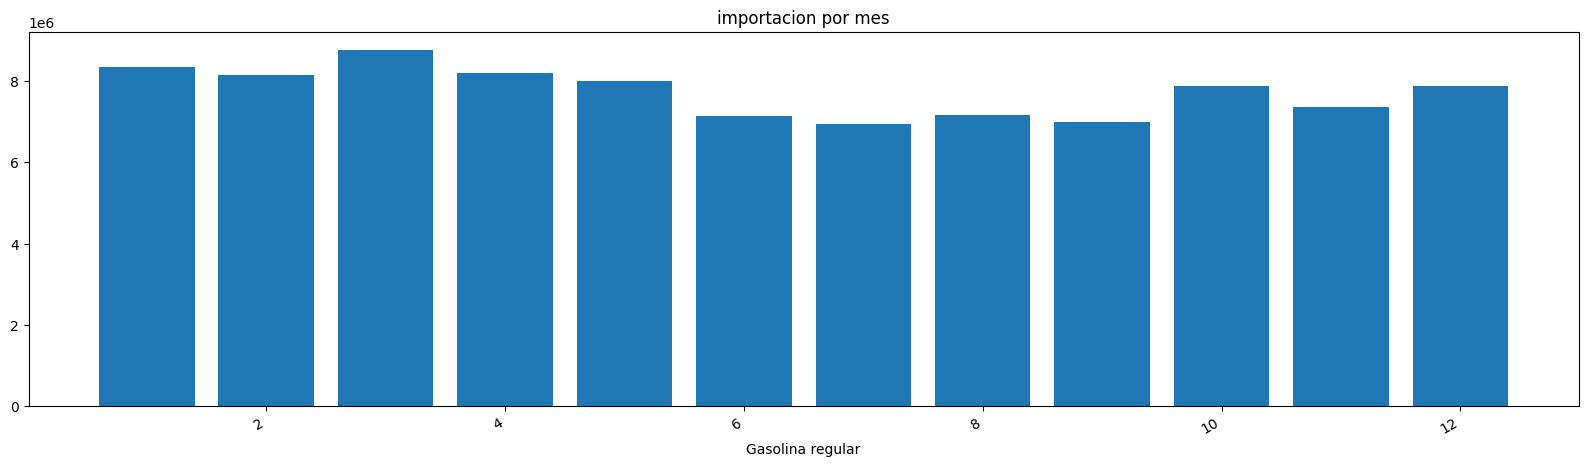

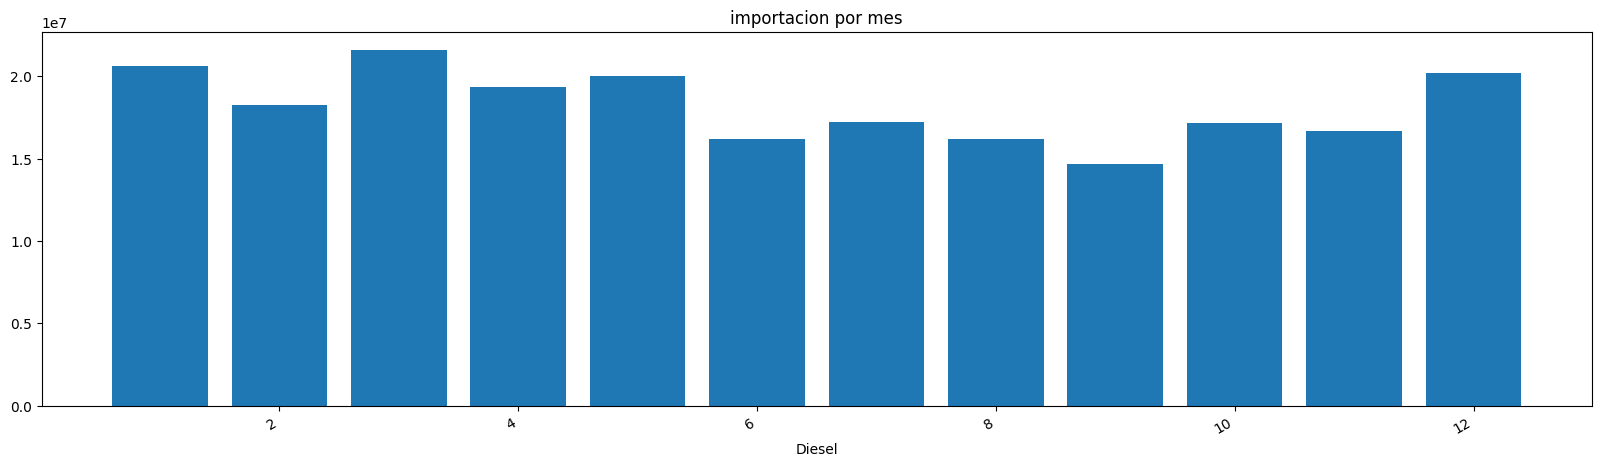

In [353]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = dfPerMonth.index
    y = dfPerMonth[gas]


    plt.title(dfToUse+" por mes")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.bar(x, y)
    plt.show()

# Comportamiento en la pandemia

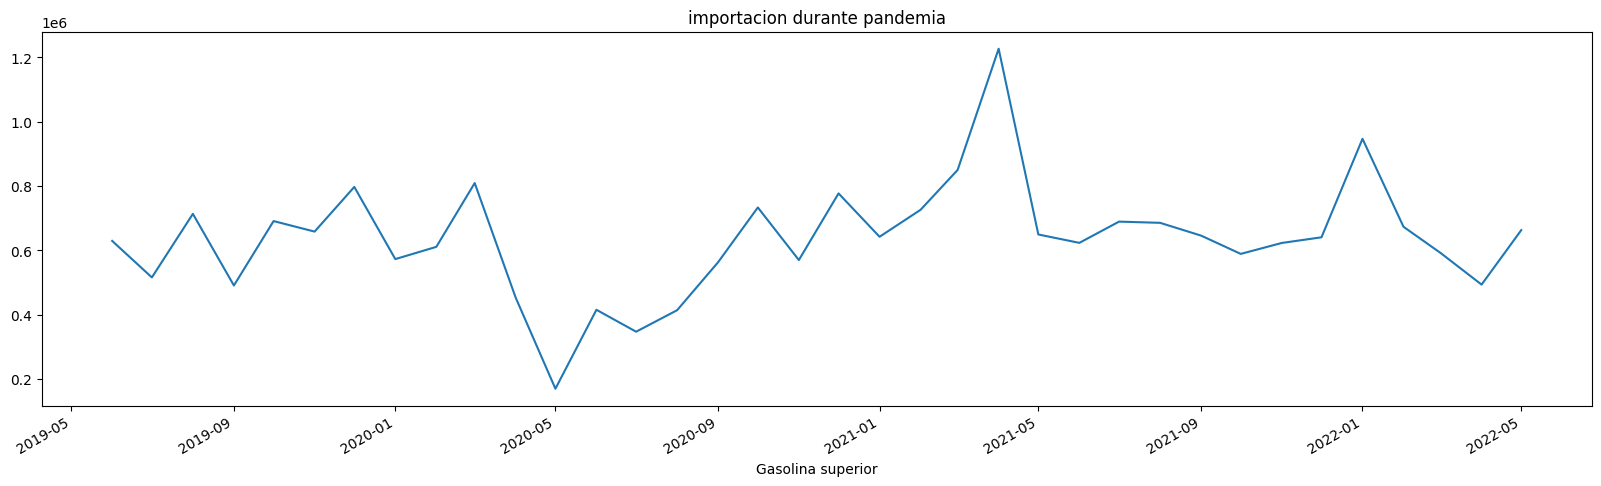

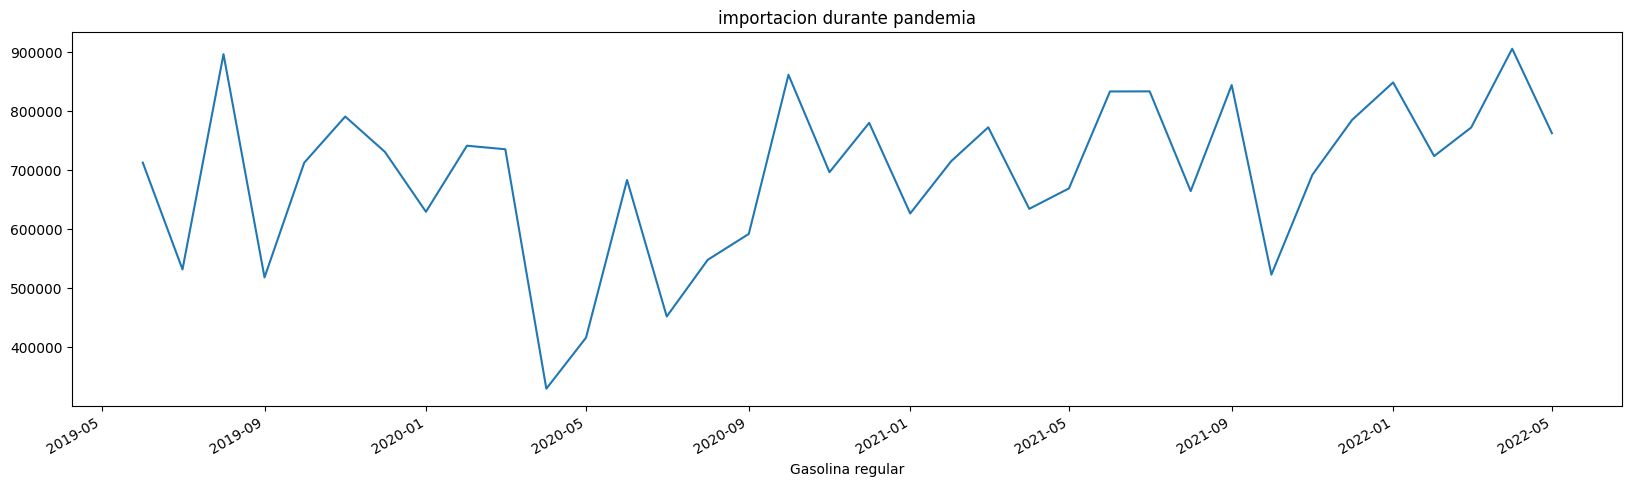

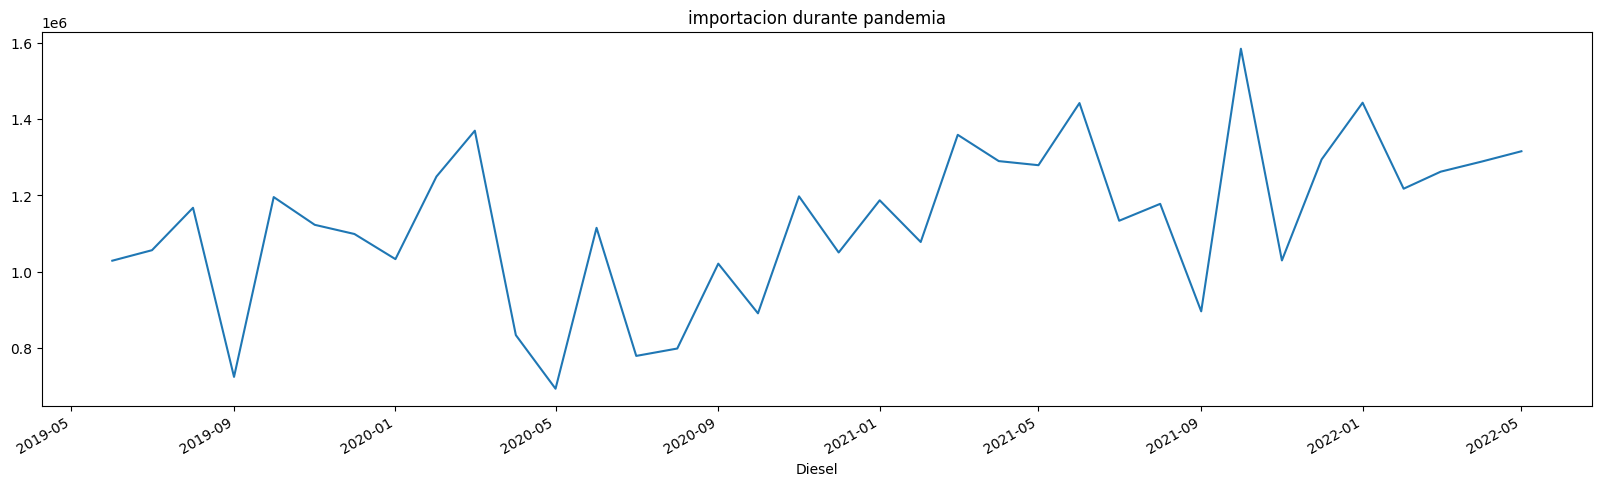

In [354]:
plt.rcParams["figure.figsize"] = (20,5.5)
quant_to_have = 12

for gas in quant_vars:
    x = df['Fecha'].tail(quant_to_have * 3)
    y = df[gas].tail(quant_to_have * 3)

    plt.title(dfToUse+" durante pandemia")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Separando test y train

In [355]:
rows = len(df)
train_df = df[0:rows-17] # 2000-01-01 a 2020-12-01
test_df = df[rows-17:] # 2021-01-01	 a 2022-05-01	
print(len(train_df), len(test_df))

240 17


## Pasos para construir modelos ARIMA
1. Identificación
2. Estimación
3. Validación
4. Predicción

In [356]:
def make_timeline(column):
  plt.rcParams["figure.figsize"] = (20,5.5)
  mediaGasoline = train_df[column].rolling(window=12).mean()
  deGasoline = train_df[column].rolling(window=12).std()

  original = plt.plot(train_df[column], color="blue", label="Original")
  media = plt.plot(mediaGasoline, color='red', label = 'Media ' + dfToUse)
  ds = plt.plot(deGasoline, color='black', label = 'Desviación Estándar ' + dfToUse)
  plt.legend(loc = 'best')
  plt.title('Media y desviación estándar ' + column)
  plt.show(block=False)

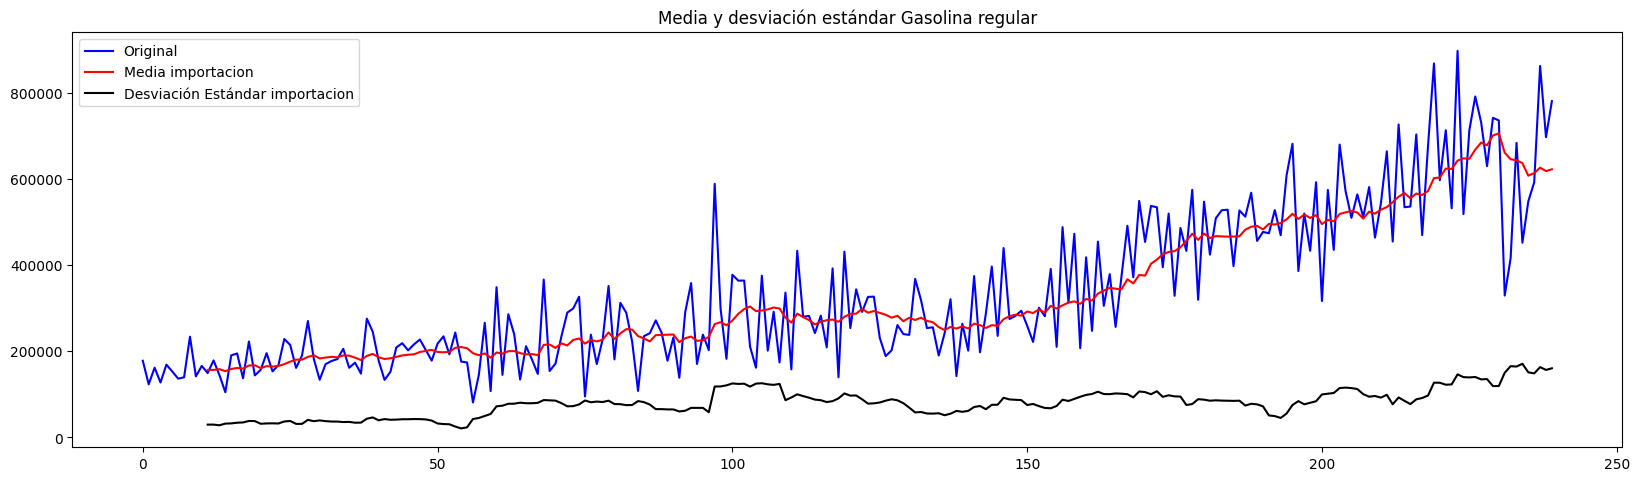

In [357]:
make_timeline(label_regular)

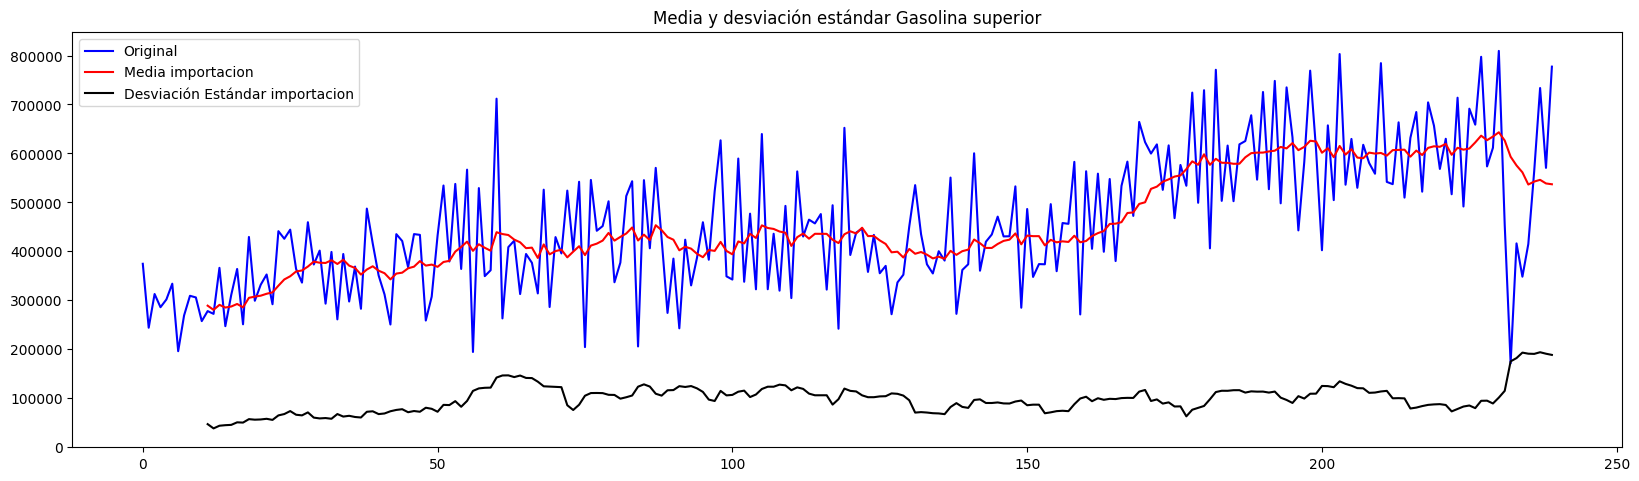

In [358]:
make_timeline(label_super)

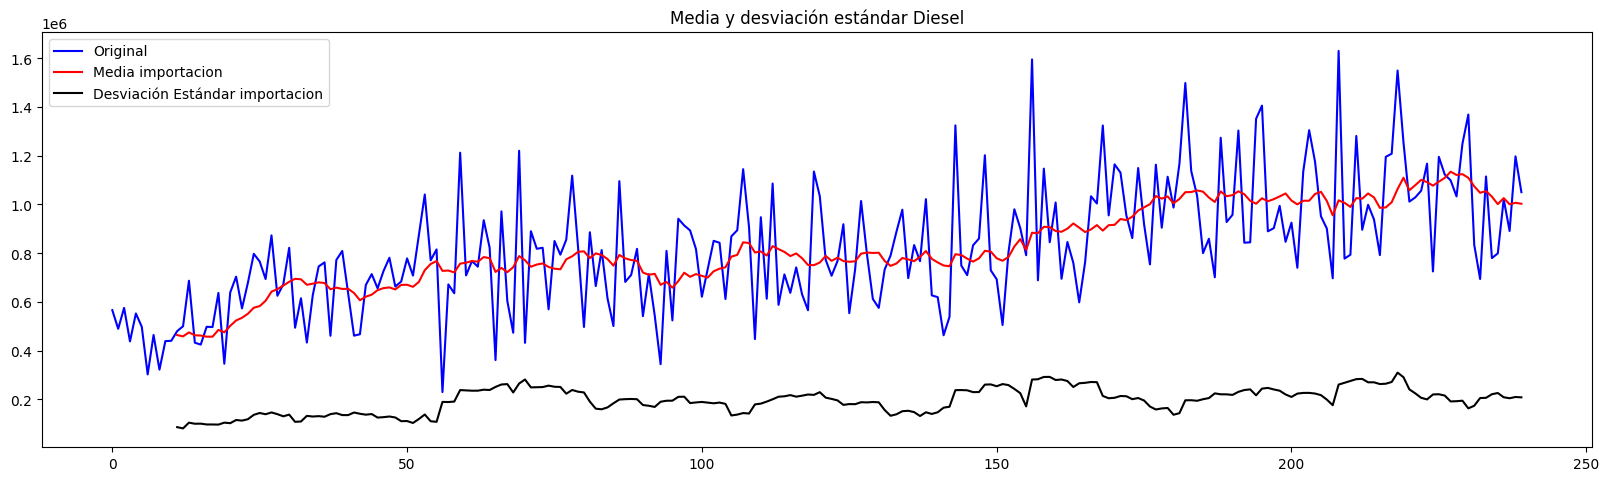

In [359]:
make_timeline(label_diesel)

In [360]:
train_regular = train_df[['Fecha', label_regular]]
train_superior = train_df[['Fecha', label_super]]
train_diesel = train_df[['Fecha', label_diesel]]

test_regular = test_df[['Fecha', label_regular]]
test_superior = test_df[['Fecha', label_super]]
test_diesel = test_df[['Fecha', label_diesel]]

In [361]:
# Gasolina regular
train_regular[label_regular] = train_regular[label_regular].astype(float)
train_regular_indexed = train_regular.set_index(['Fecha'])
# Gasolina superior
train_superior[label_super] = train_superior[label_super].astype(float)
train_superior_indexed = train_superior.set_index(['Fecha'])
# Gasolina diesel
train_diesel[label_diesel] = train_diesel[label_diesel].astype(float)
train_diesel_indexed = train_diesel.set_index(['Fecha'])


######### TEST ###############
# Gasolina regular
test_regular[label_regular] = test_regular[label_regular].astype(float)
test_regular_indexed = test_regular.set_index(['Fecha'])
# Gasolina superior
test_superior[label_super] = test_superior[label_super].astype(float)
test_superior_indexed = test_superior.set_index(['Fecha'])
# Gasolina diesel
test_diesel[label_diesel] = test_diesel[label_diesel].astype(float)
test_diesel_indexed = test_diesel.set_index(['Fecha'])

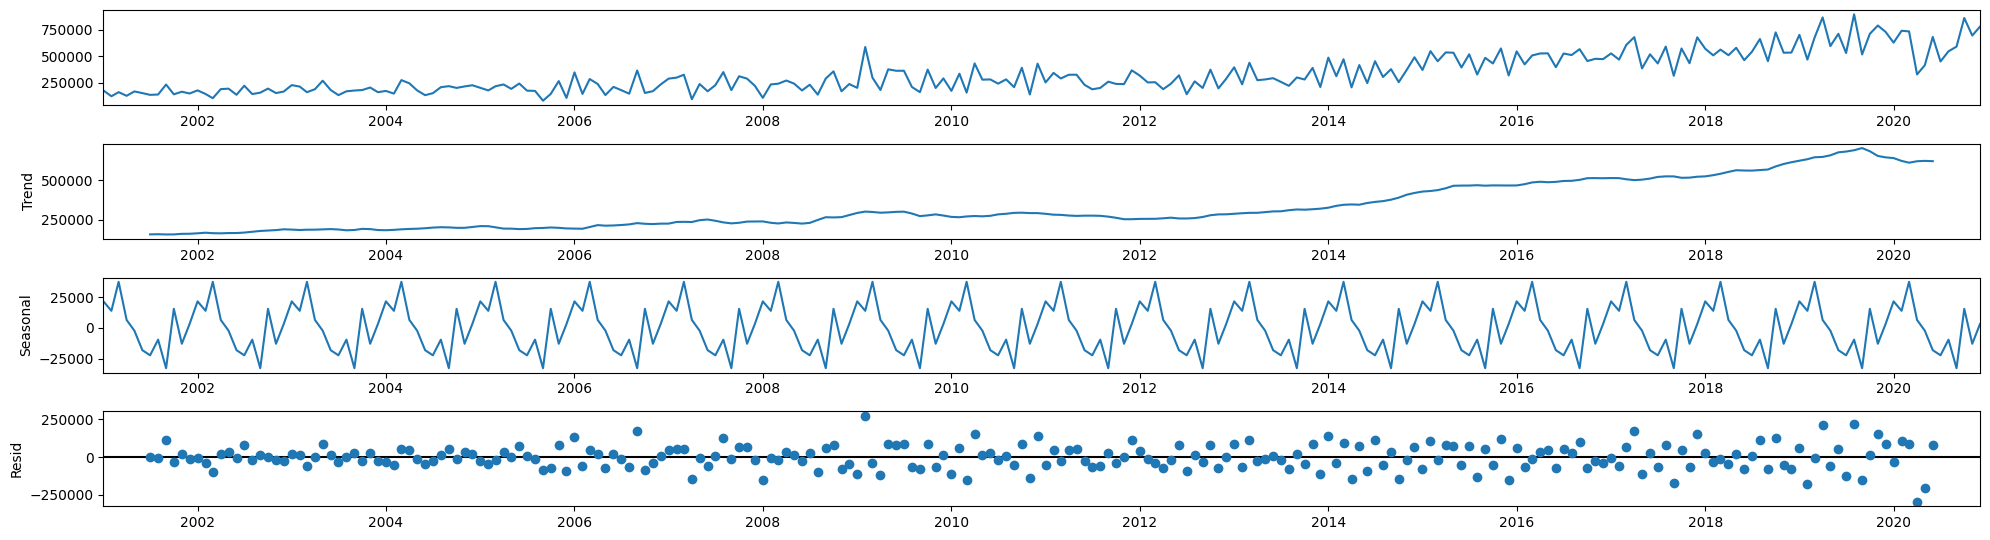

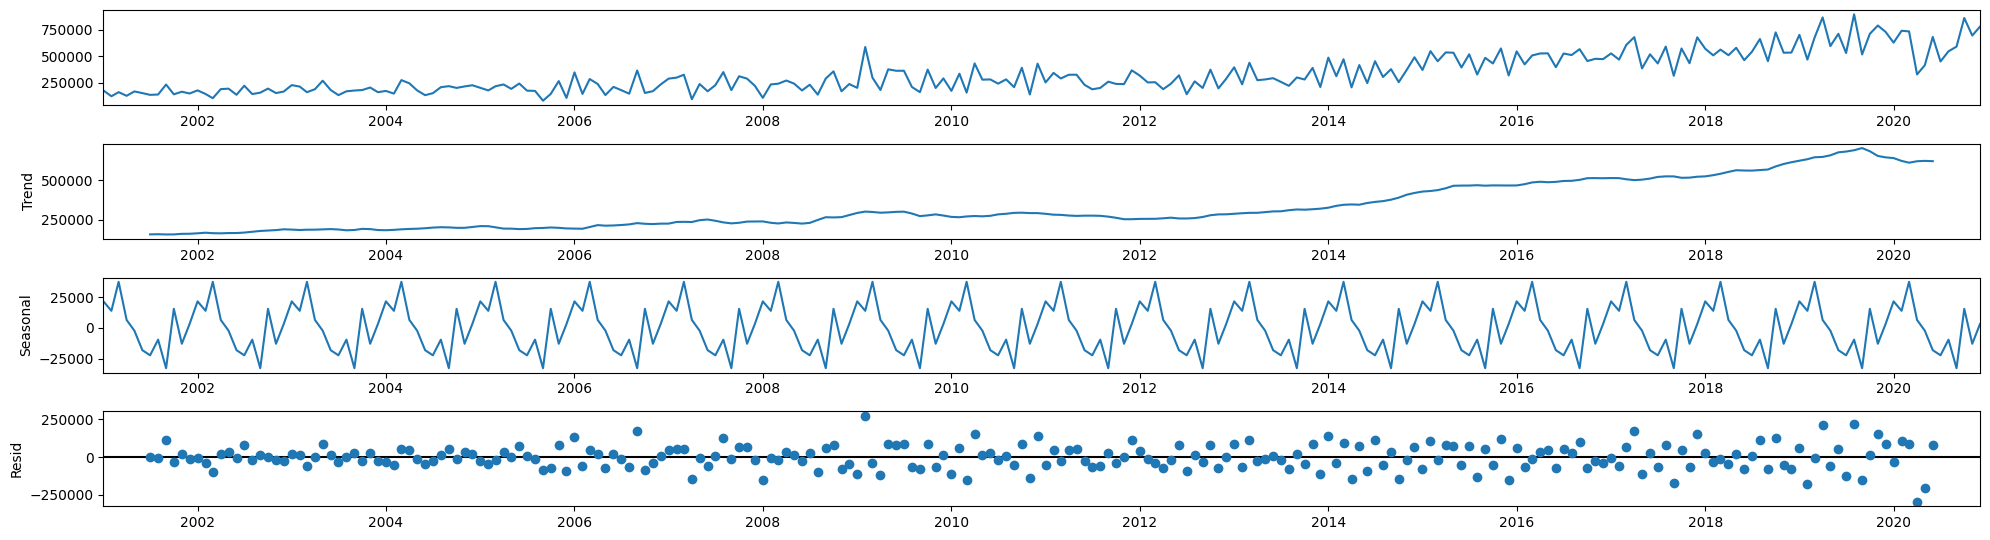

In [362]:
descomposicion = seasonal_decompose(train_regular_indexed)
descomposicion.plot()

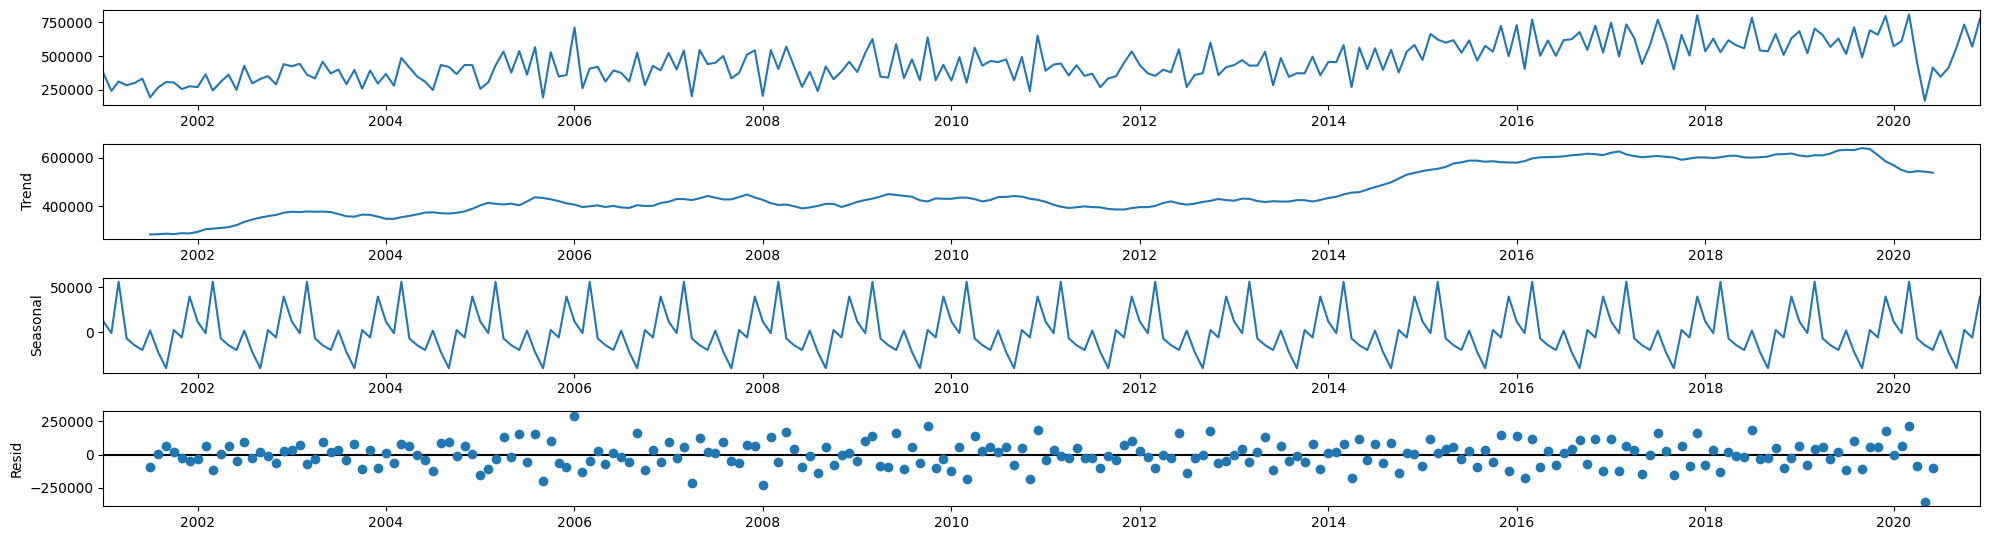

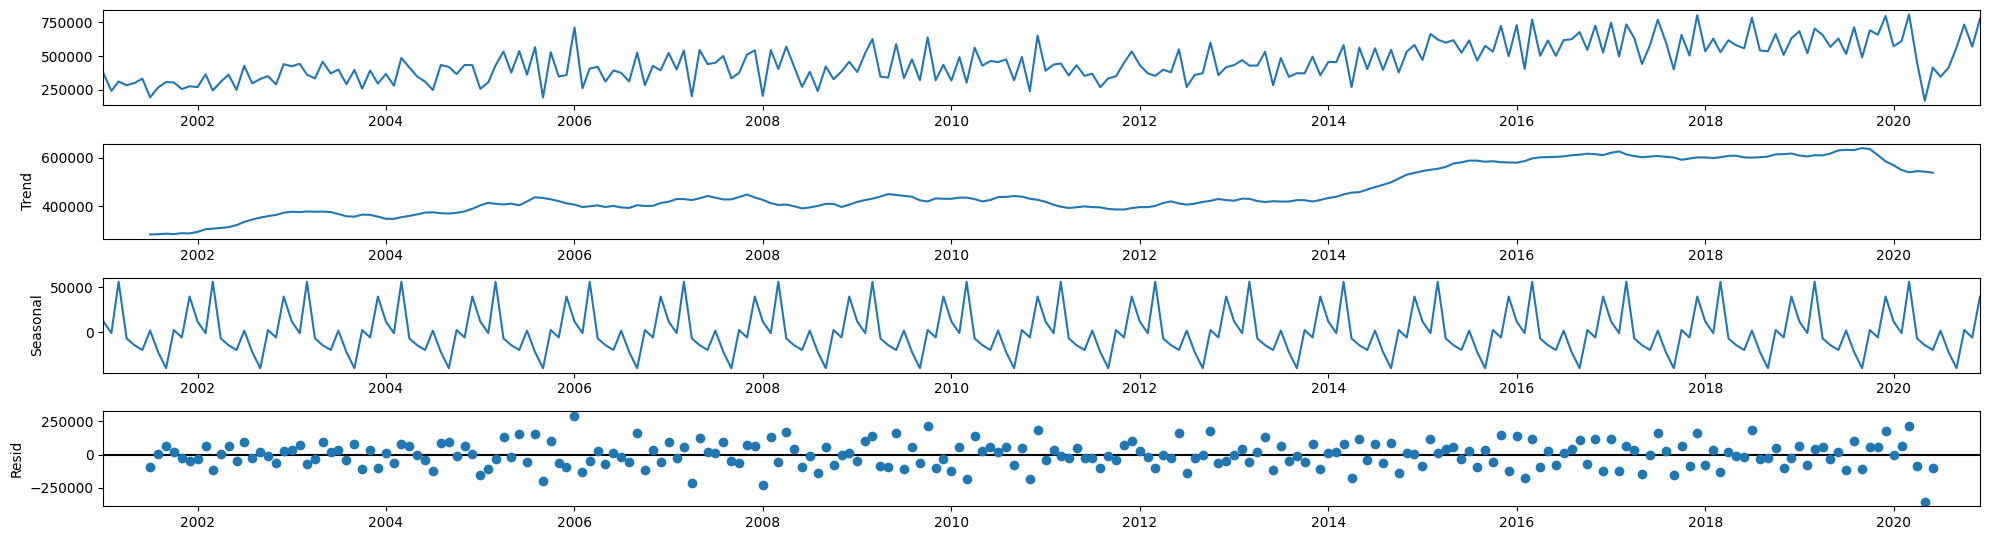

In [363]:
descomposicion = seasonal_decompose(train_superior_indexed)
descomposicion.plot()

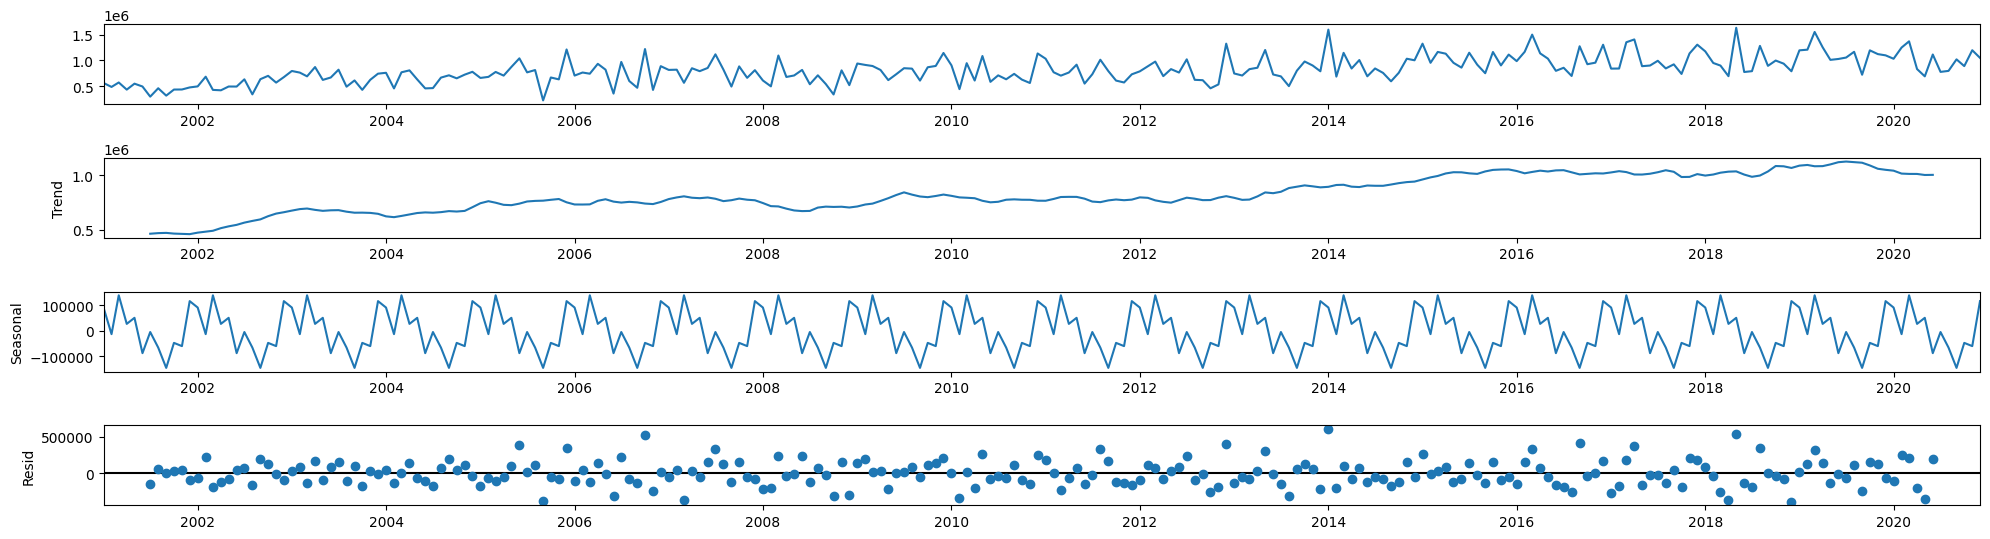

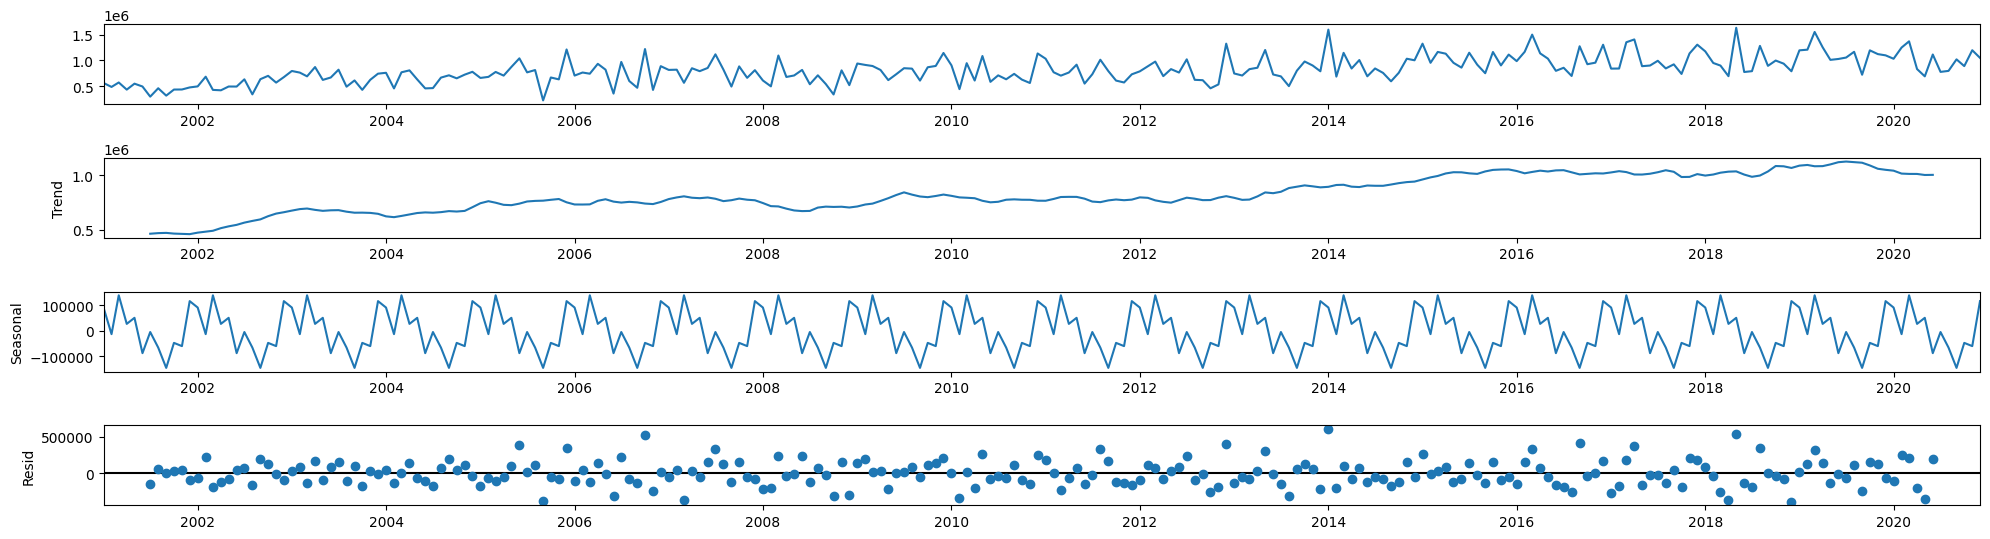

In [364]:
descomposicion = seasonal_decompose(train_diesel_indexed)
descomposicion.plot()

# Estimación

In [430]:
# 2000-01-01 a 2019-12-01
removeCovid = 228
if dfToUse == 'consumo':
    removeCovid = 240


train_regular_indexed = train_regular_indexed[0:removeCovid]
train_superior_indexed = train_superior_indexed[0:removeCovid]
train_diesel_indexed = train_diesel_indexed[0:removeCovid]

In [431]:
train_regular_gas = train_regular_indexed[label_regular]
train_superior_gas = train_superior_indexed[label_super]
train_diesel_gas = train_diesel_indexed[label_diesel]

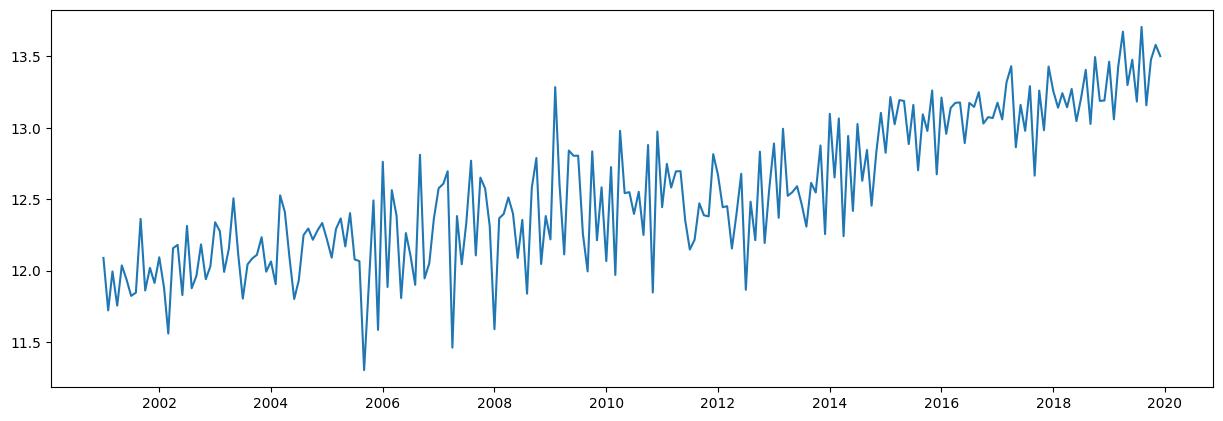

In [432]:
train_regular_log = np.log(train_regular_gas)
plt.plot(train_regular_log)

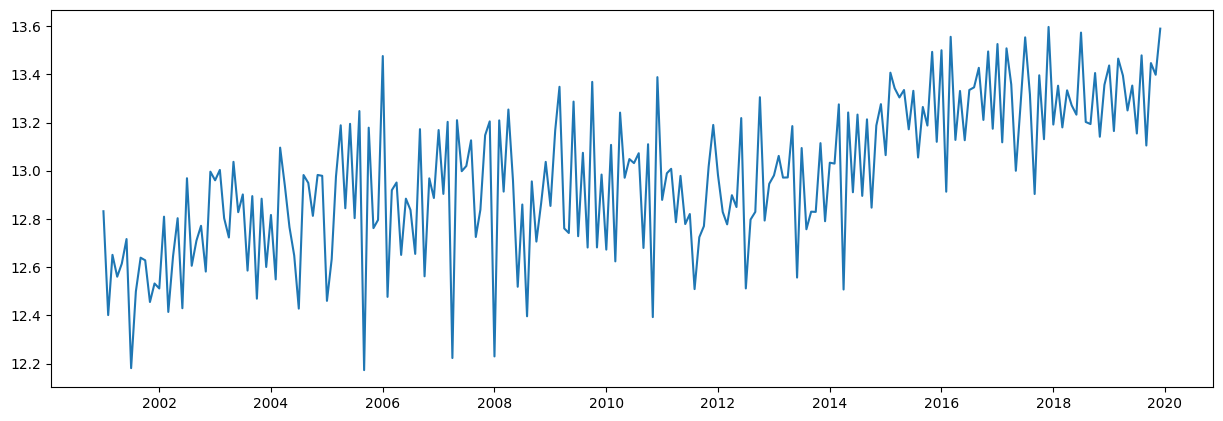

In [433]:
train_superior_log = np.log(train_superior_gas)
plt.plot(train_superior_log)

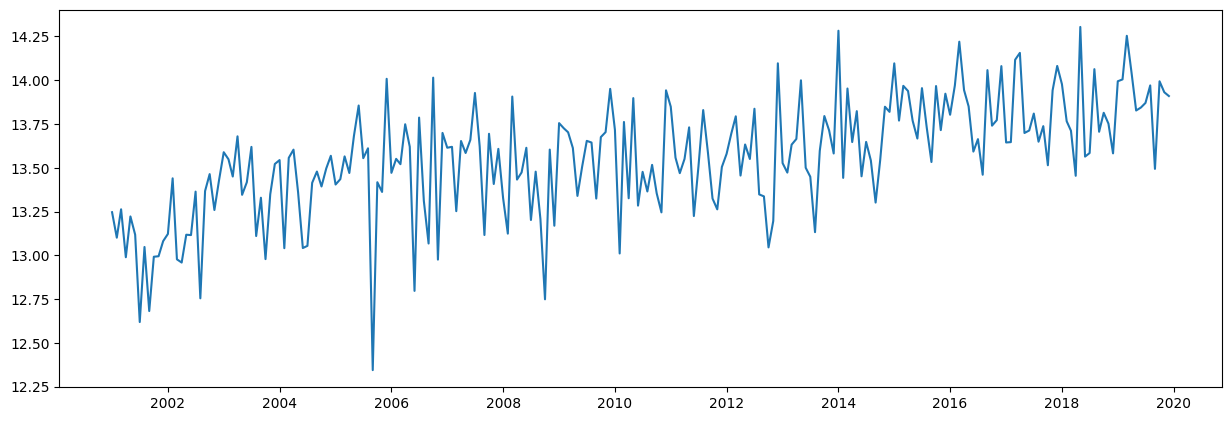

In [434]:
train_diesel_log = np.log(train_diesel_gas)
plt.plot(train_diesel_log)

Con esta transformación pudimos estacionarizarla en varianza debido a que los picos se mantienen

## Regular

In [435]:
print('Resultados del Test de Dickey Fuller ' + label_regular)
dfTest = adfuller(train_regular_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller Gasolina regular
Estadístico de prueba          1.767979
p-value                        0.998283
# de retardos usados           9.000000
# de observaciones usadas    218.000000
Critical Value (1%)           -3.460708
Critical Value (5%)           -2.874891
Critical Value (10%)          -2.573886
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [436]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie ' + label_regular)
train_regular_gas_log_diff = train_regular_gas.diff()
train_regular_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_regular_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie Gasolina regular
Estadístico de prueba       -8.599098e+00
p-value                      6.947043e-14
# de retardos usados         8.000000e+00
# de observaciones usadas    2.180000e+02
Critical Value (1%)         -3.460708e+00
Critical Value (5%)         -2.874891e+00
Critical Value (10%)        -2.573886e+00
dtype: float64


El p-value es menor a 0.05 por lo que se rechaza la hipótesis nula. La serie es estacionaria en media con un d=1

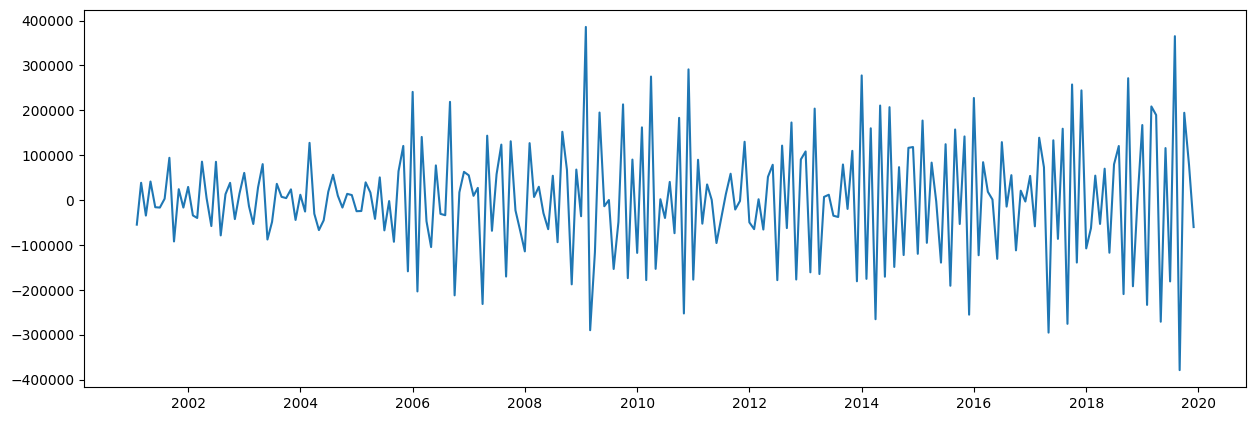

In [437]:
plt.plot(train_regular_gas_log_diff)

## Superior

In [438]:
print('Resultados del Test de Dickey Fuller ' + label_super)
dfTest = adfuller(train_superior_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller Gasolina superior
Estadístico de prueba         -0.763154
p-value                        0.829707
# de retardos usados          10.000000
# de observaciones usadas    217.000000
Critical Value (1%)           -3.460849
Critical Value (5%)           -2.874953
Critical Value (10%)          -2.573919
dtype: float64


In [439]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie ' + label_super)
train_superior_gas_log_diff = train_superior_gas.diff()
train_superior_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_superior_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie Gasolina superior
Estadístico de prueba       -7.933659e+00
p-value                      3.459311e-12
# de retardos usados         9.000000e+00
# de observaciones usadas    2.170000e+02
Critical Value (1%)         -3.460849e+00
Critical Value (5%)         -2.874953e+00
Critical Value (10%)        -2.573919e+00
dtype: float64


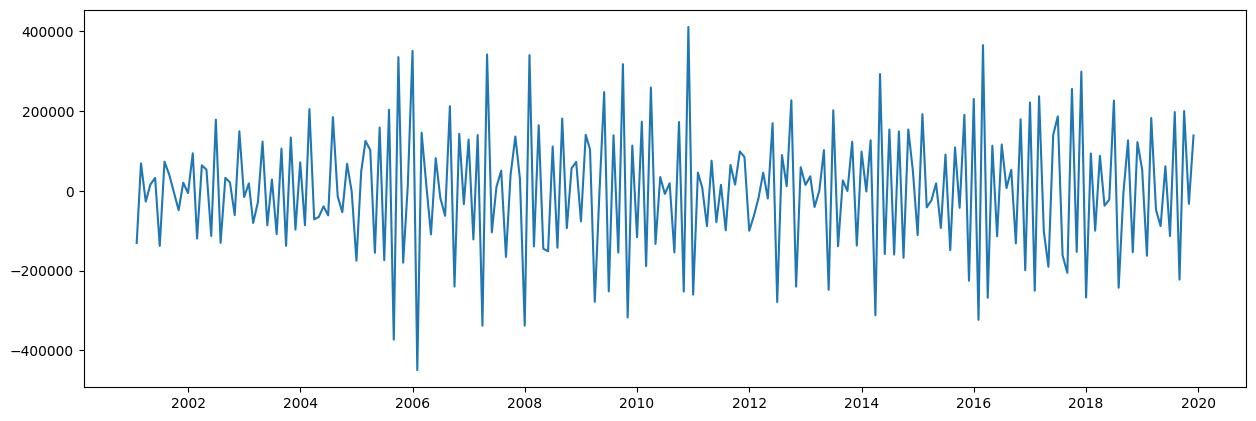

In [440]:
plt.plot(train_superior_gas_log_diff)

## Diesel

In [441]:
print('Resultados del Test de Dickey Fuller ' + label_diesel)
dfTest = adfuller(train_diesel_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller Diesel
Estadístico de prueba         -1.279312
p-value                        0.638583
# de retardos usados          13.000000
# de observaciones usadas    214.000000
Critical Value (1%)           -3.461282
Critical Value (5%)           -2.875143
Critical Value (10%)          -2.574020
dtype: float64


In [442]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie ' + label_diesel)
train_diesel_gas_log_diff = train_diesel_gas.diff()
train_diesel_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_diesel_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie Diesel
Estadístico de prueba       -8.650661e+00
p-value                      5.126057e-14
# de retardos usados         1.200000e+01
# de observaciones usadas    2.140000e+02
Critical Value (1%)         -3.461282e+00
Critical Value (5%)         -2.875143e+00
Critical Value (10%)        -2.574020e+00
dtype: float64


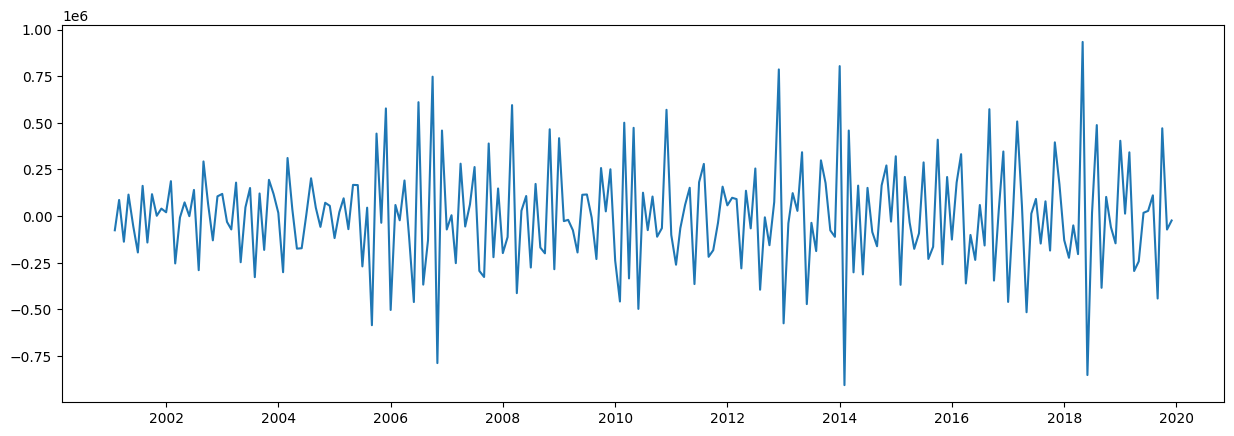

In [443]:
plt.plot(train_diesel_gas_log_diff)

## Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [444]:
def getTSA(train_gas_diff):
  tsa_acf = acf(train_gas_diff,nlags=5,fft=False)
  tsa_pacf = pacf(train_gas_diff, nlags=36)
  return [tsa_acf, tsa_pacf]

In [445]:
def plotACF(train_gas_diff):
  plt.rcParams['figure.figsize'] = [15, 5]
  plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

  #Plot ACF: 
  plt.subplot(121) 
  plt.plot(acf(train_gas_diff,nlags=36,fft=False))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación con 36 retardos')

  plt.subplot(122) 
  plt.plot(acf(train_gas_diff,nlags=5,fft=False))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación con 5 retardos')

  plt.tight_layout()

In [446]:
#plot PACF
def plotPACF(train_gas_diff):
  plt.subplot(121)
  plt.plot(pacf(train_gas_diff, nlags=36))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación Parcial 36 retardos')

  plt.subplot(122)
  plt.plot(pacf(train_gas_diff, nlags=5))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación Parcial 5 retardos')

  plt.rcParams['figure.figsize'] = [15, 5]
  plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [447]:
def checkStationarity(train_gas_diff):
  plt.plot(acf(train_gas_diff,nlags=36,fft=False))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación con 36 retardos')
  plt.rcParams['figure.figsize'] = [15, 5]
  plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [448]:
def autoCorr(train_log_diff):
  plt.plot(pacf(train_log_diff, nlags=8))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación Parcial 8 retardos')

### Regular

In [449]:
train_regular_gas_diff = train_regular_log.diff()
train_regular_gas_diff.dropna(inplace = True)
[tsa_acf_regular, tsa_pacf_regular] = getTSA(train_regular_gas_diff)
tsa_acf_regular

array([ 1.        , -0.65298705,  0.25388422, -0.15613946,  0.0464216 ,
        0.05884339])

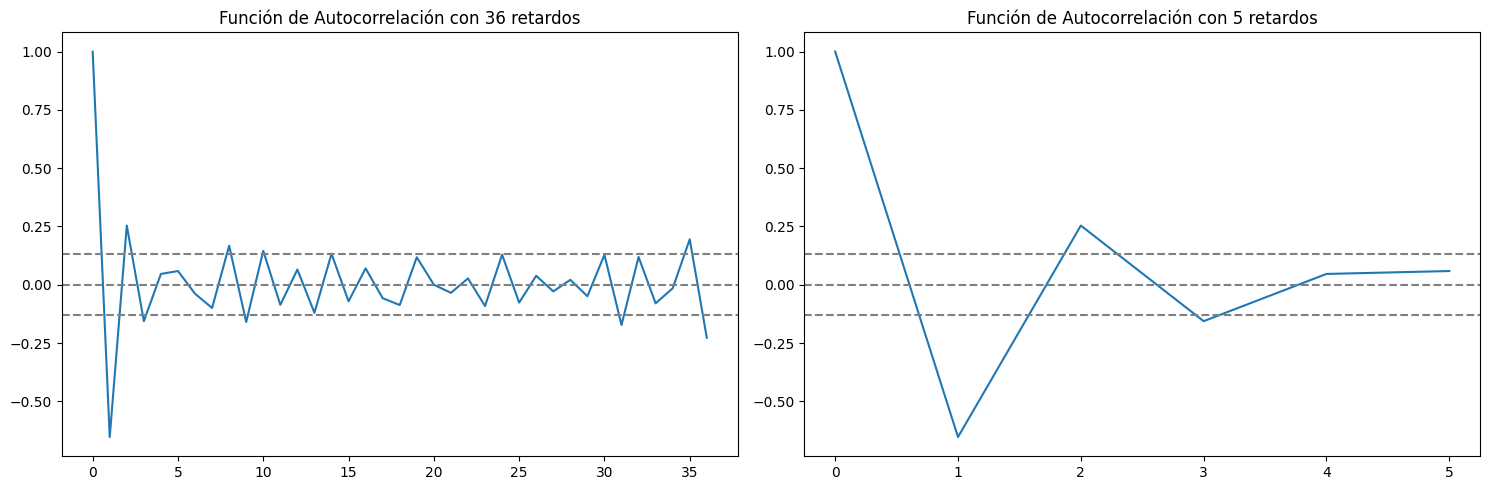

In [450]:
plotACF(train_regular_gas_diff)

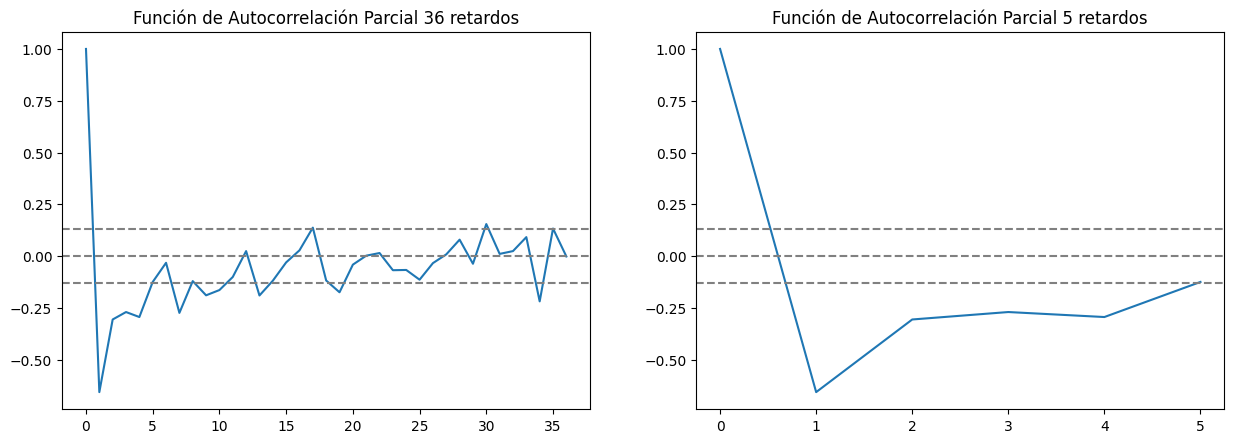

In [451]:
plotPACF(train_regular_gas_diff)

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionariedad

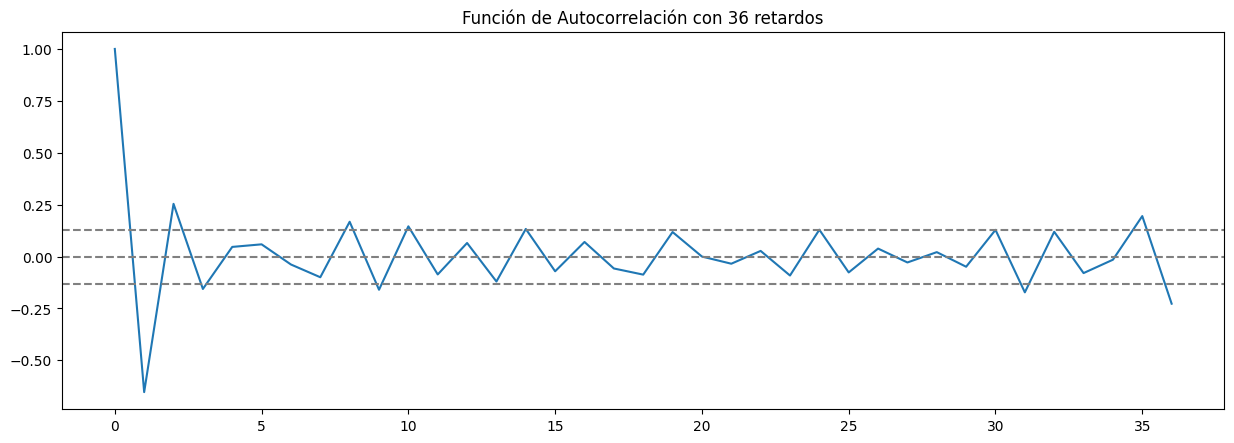

In [452]:
checkStationarity(train_regular_gas_diff)

Como se puede observar el comportamiento es similar entre 3 - 12 y 15 - 24 (estacionalidad)

In [489]:
diffToUse = 12
if (dfToUse == "importacion"):
    diffToUse = 6

train_regular_log_diff = train_regular_log.diff(diffToUse)
train_regular_log_diff.dropna(inplace=True)

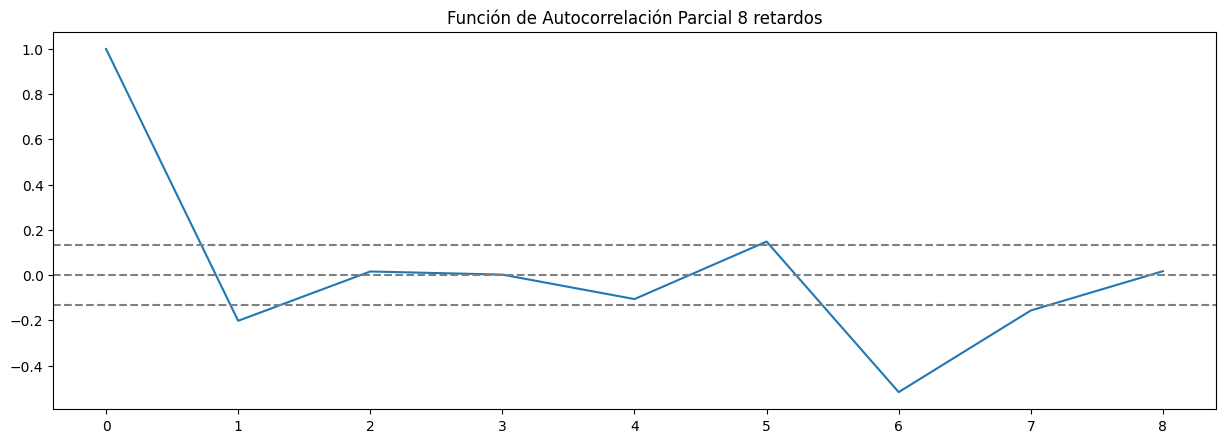

In [490]:
autoCorr(train_regular_log_diff)

Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 3
- D = 1
- Q = 0

### Superior

In [557]:
train_superior_gas_diff = train_superior_log.diff()
train_superior_gas_diff.dropna(inplace = True)
[tsa_acf_superior, tsa_pacf_superior] = getTSA(train_superior_gas_diff)
tsa_acf_superior

array([ 1.        , -0.71425802,  0.35442757, -0.21805307,  0.11593381,
       -0.06993144])

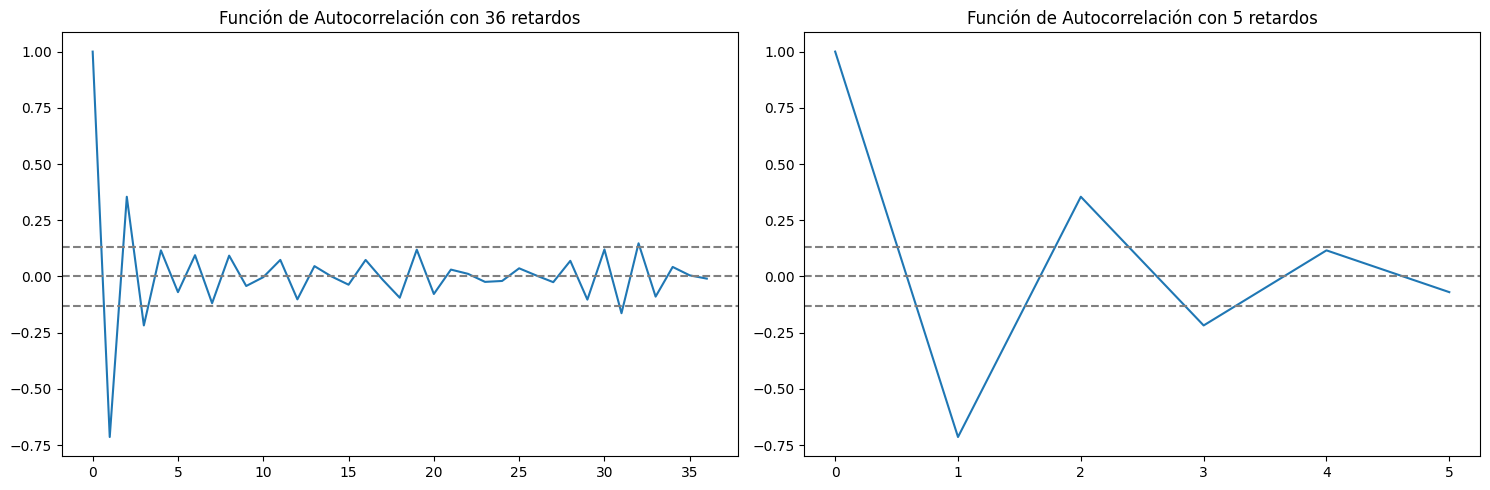

In [558]:
plotACF(train_superior_gas_diff)

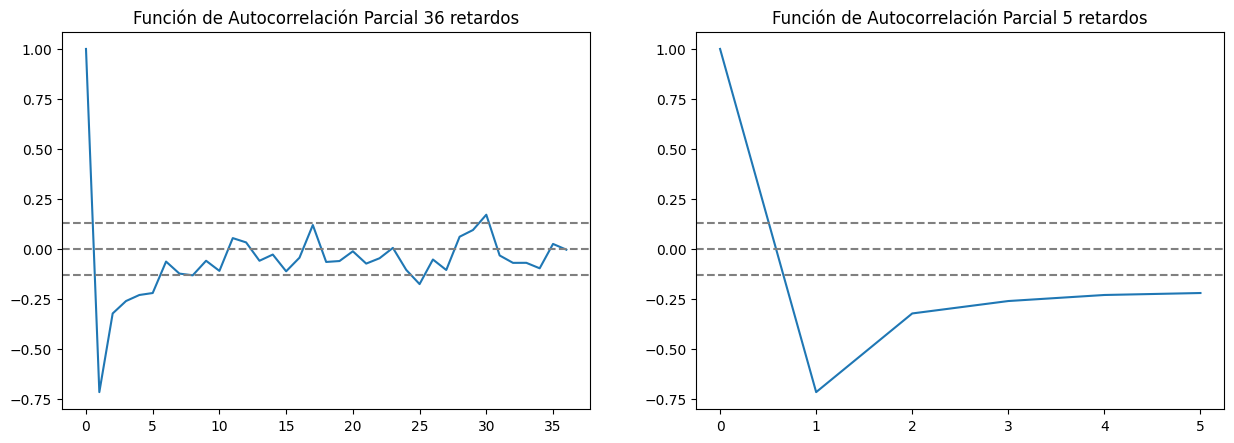

In [559]:
plotPACF(train_superior_gas_diff)

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionariedad

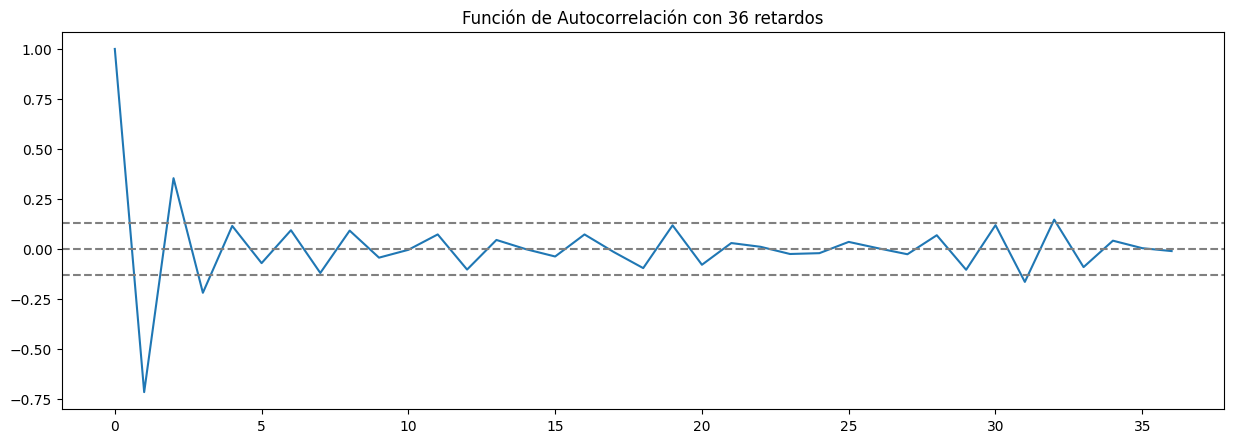

In [560]:
checkStationarity(train_superior_gas_diff)

In [561]:
train_superior_log_diff = train_superior_log.diff(diffToUse)
train_superior_log_diff.dropna(inplace=True)

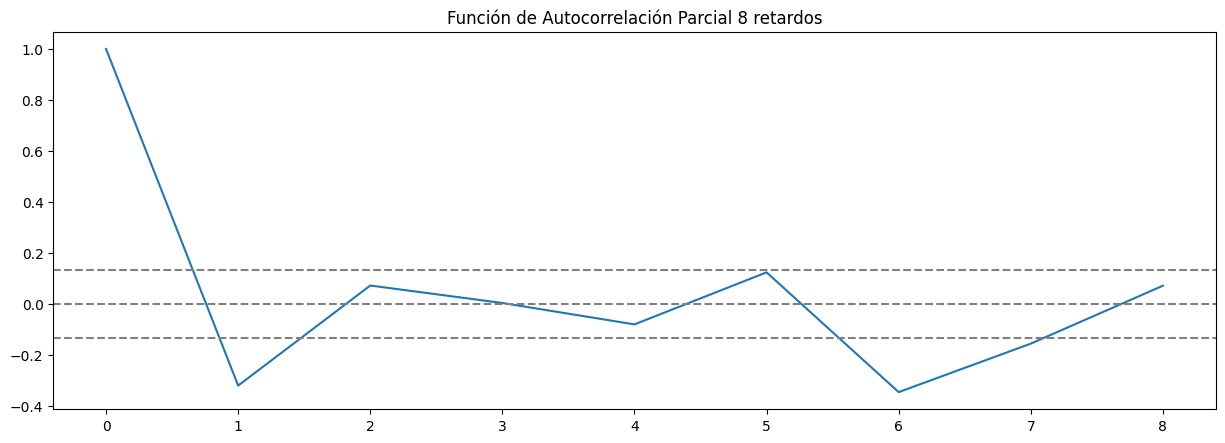

In [562]:
autoCorr(train_superior_log_diff)

Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 5
- D = 1
- Q = 0

### Diesel

In [563]:
train_diesel_gas_diff = train_diesel_log.diff()
train_diesel_gas_diff.dropna(inplace = True)
[tsa_acf_diesel, tsa_pacf_diesel] = getTSA(train_diesel_gas_diff)
tsa_acf_diesel

array([ 1.        , -0.53803333,  0.08231187, -0.02553409, -0.07605124,
        0.13948885])

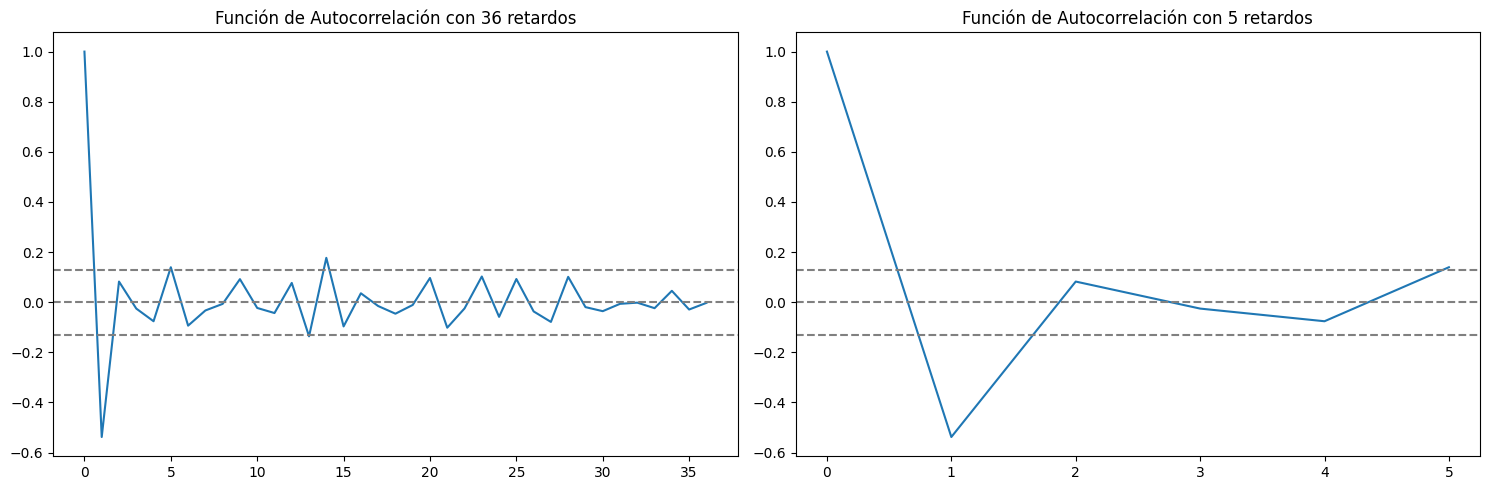

In [564]:
plotACF(train_diesel_gas_diff)

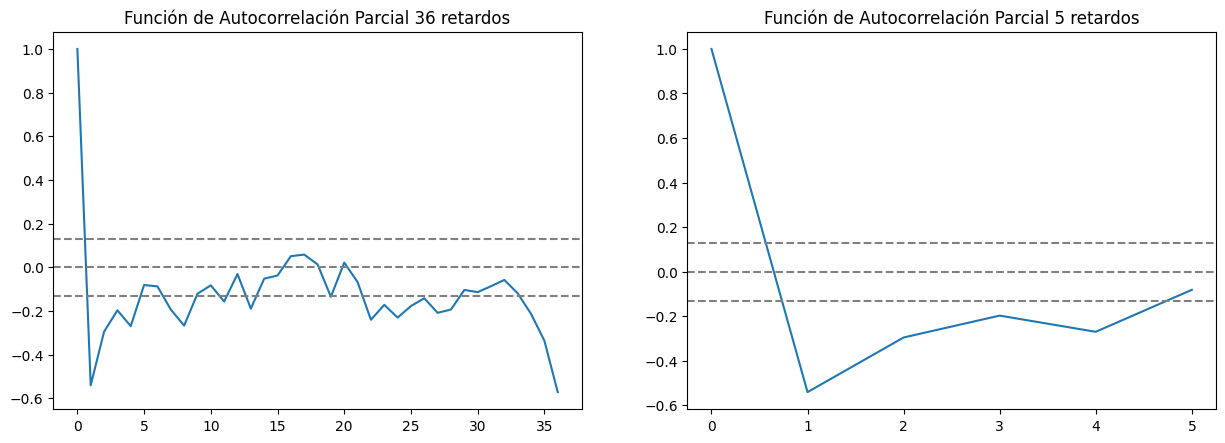

In [565]:
plotPACF(train_diesel_gas_diff)

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionariedad

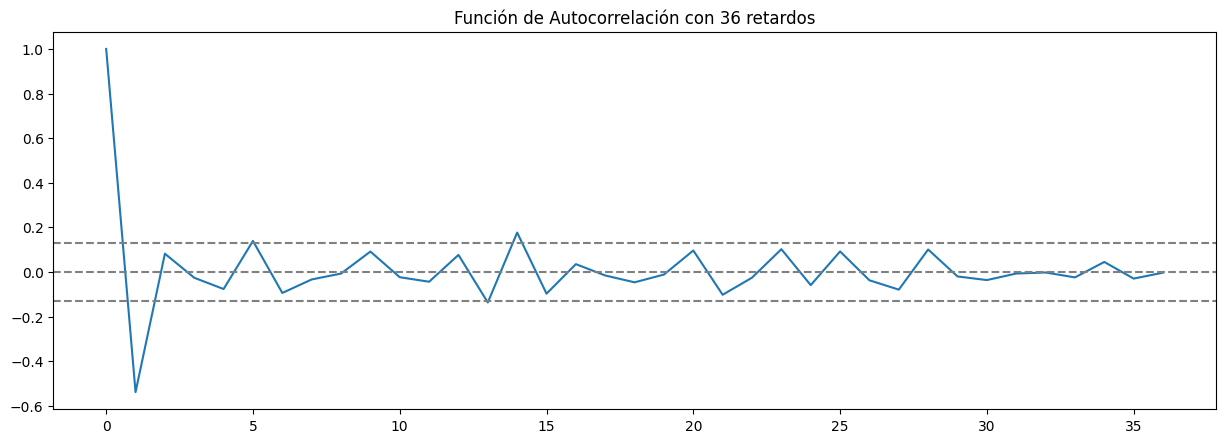

In [566]:
checkStationarity(train_diesel_gas_diff)

In [567]:
train_diesel_log_diff = train_diesel_log.diff(12)
train_diesel_log_diff.dropna(inplace=True)

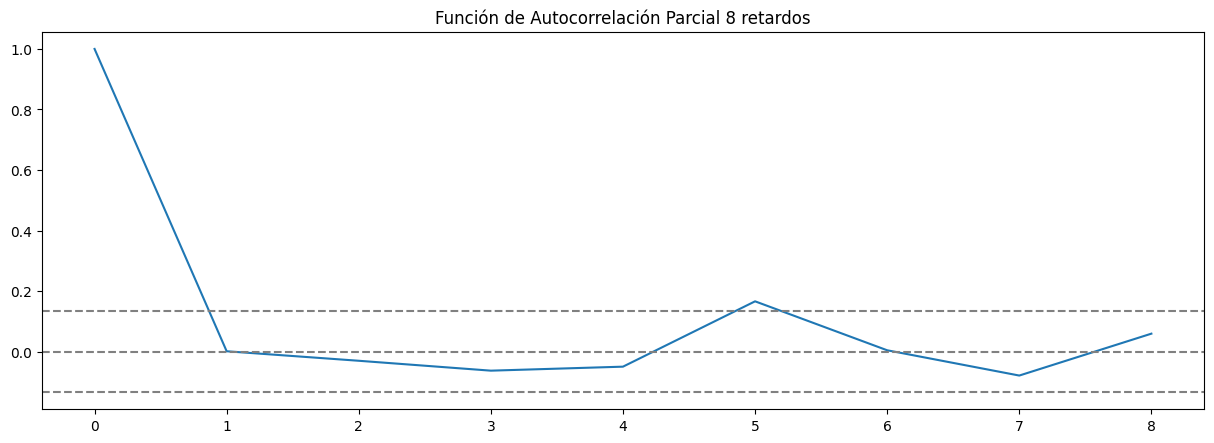

In [568]:
autoCorr(train_diesel_log_diff)

Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 3
- D = 1
- Q = 0

## Analisis residuos

## Regular

In [604]:
seasonalOrder = 3
if (dfToUse == "importacion"):
  seasonalOrder = 0

model_regular_121 = SARIMAX(
  train_regular_log,
  order=(1,2,1),
  seasonal_order=(seasonalOrder,1,0,diffToUse),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_regular_121 = model_regular_121.fit()
print(resultado_regular_121.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6071      0.050    -12.037      0.000      -0.706      -0.508
ma.L1         -1.0000    198.426     -0.005      0.996    -389.907     387.907
sigma2         0.2398     47.581      0.005      0.996     -93.018      93.497


c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


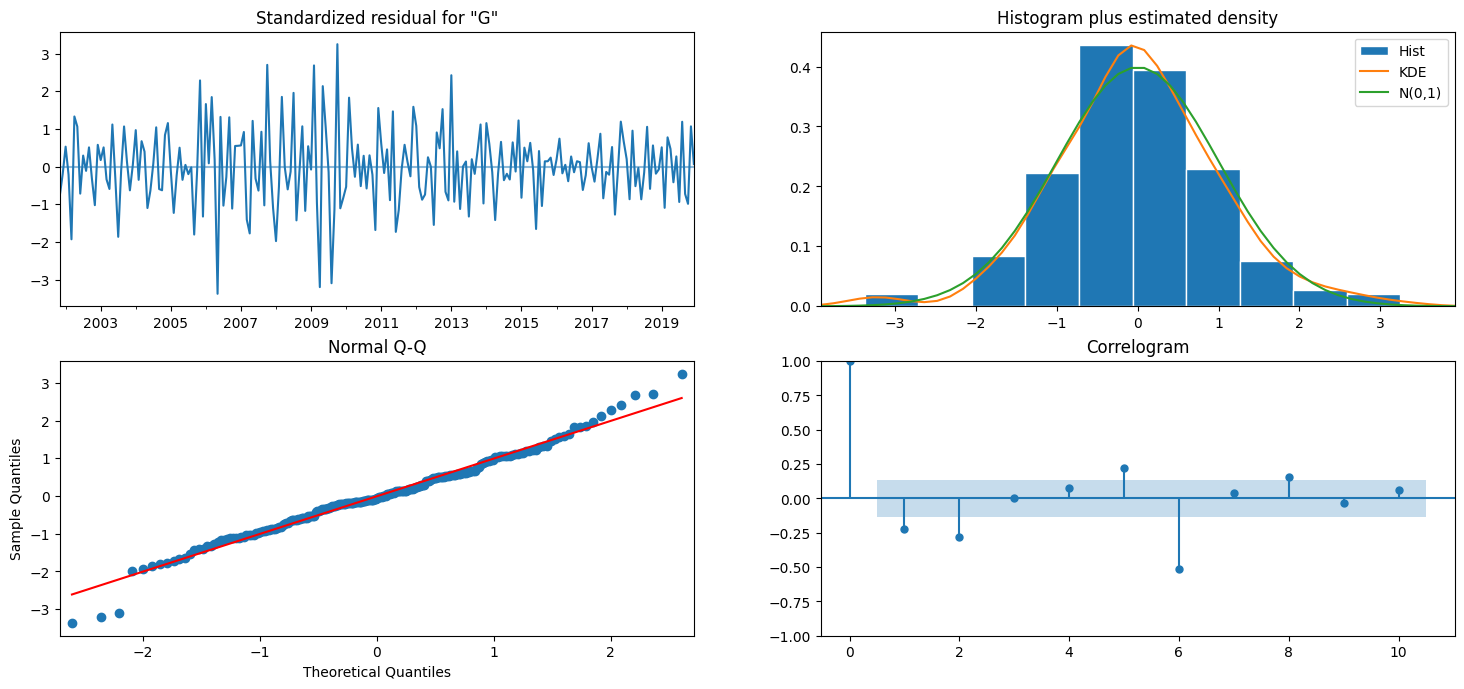

In [605]:
resultado_regular_121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [606]:
model_regular_221 = SARIMAX(
  train_regular_log,
  order=(2,2,1),
  seasonal_order=(seasonalOrder,1,0,diffToUse),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_regular_221 = model_regular_221.fit(disp=False)
print(resultado_regular_221.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8320      0.069    -12.086      0.000      -0.967      -0.697
ar.L2         -0.3683      0.060     -6.182      0.000      -0.485      -0.251
ma.L1         -1.0000    179.209     -0.006      0.996    -352.243     350.243
sigma2         0.2069     37.085      0.006      0.996     -72.479      72.893


c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


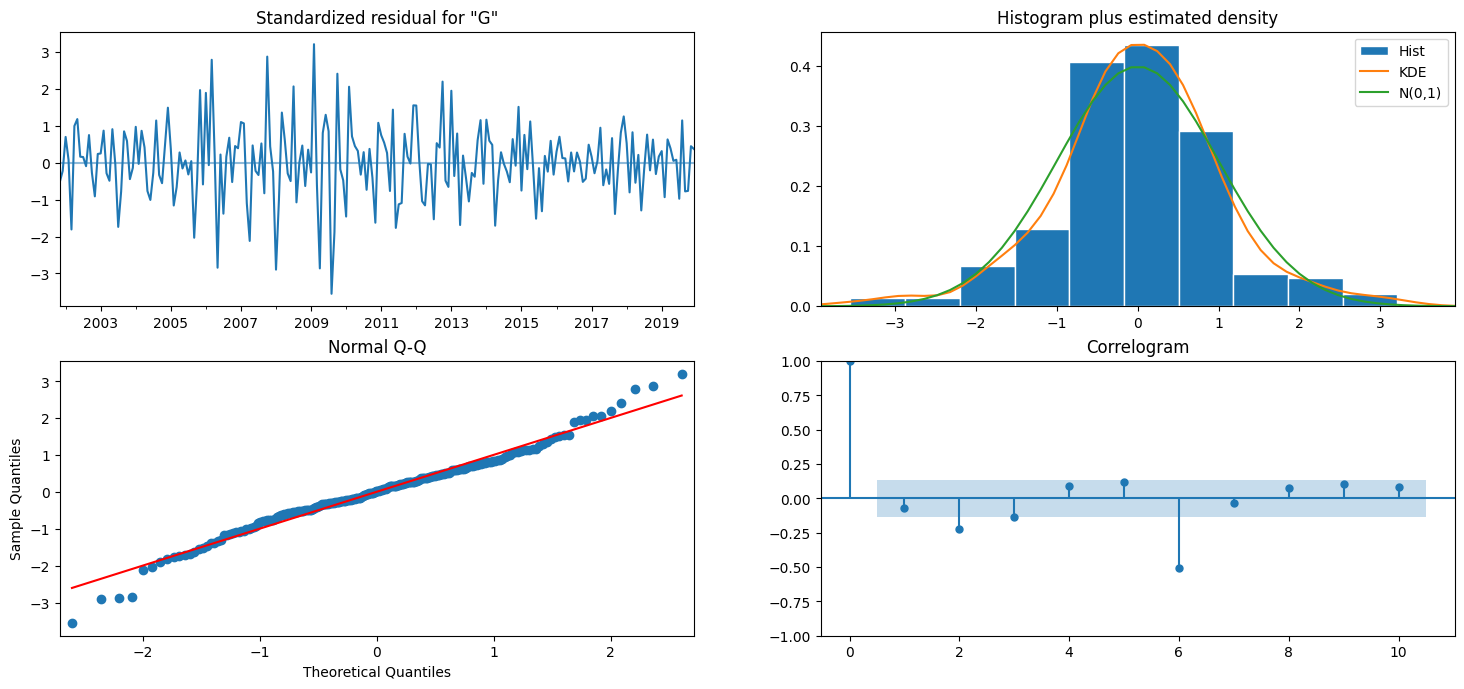

In [607]:
resultado_regular_221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [608]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_regular_121.aic)
print("Modelo 221=",resultado_regular_221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_regular_121.bic)
print("Modelo 221=",resultado_regular_221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= 318.06662419265643
Modelo 221= 288.6324001248077
Resultados de BIC (Bayesian information criterion)
Modelo 121= 328.2201093810237
Modelo 221= 302.17038037596404


De acuerdo a ambos indicadores es mejor el modelo p=2, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Superior

In [609]:
seasonalOrderSuperior = 5
if (dfToUse == "importacion"):
  seasonalOrderSuperior = 0

model_superior_121 = SARIMAX(
  train_superior_log,
  order=(1,2,1),
  seasonal_order=(seasonalOrderSuperior,1,0,diffToUse),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_superior_121 = model_superior_121.fit()
print(resultado_superior_121.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6835      0.050    -13.712      0.000      -0.781      -0.586
ma.L1         -1.0000    168.691     -0.006      0.995    -331.628     329.628
sigma2         0.1296     21.869      0.006      0.995     -42.732      42.991


c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


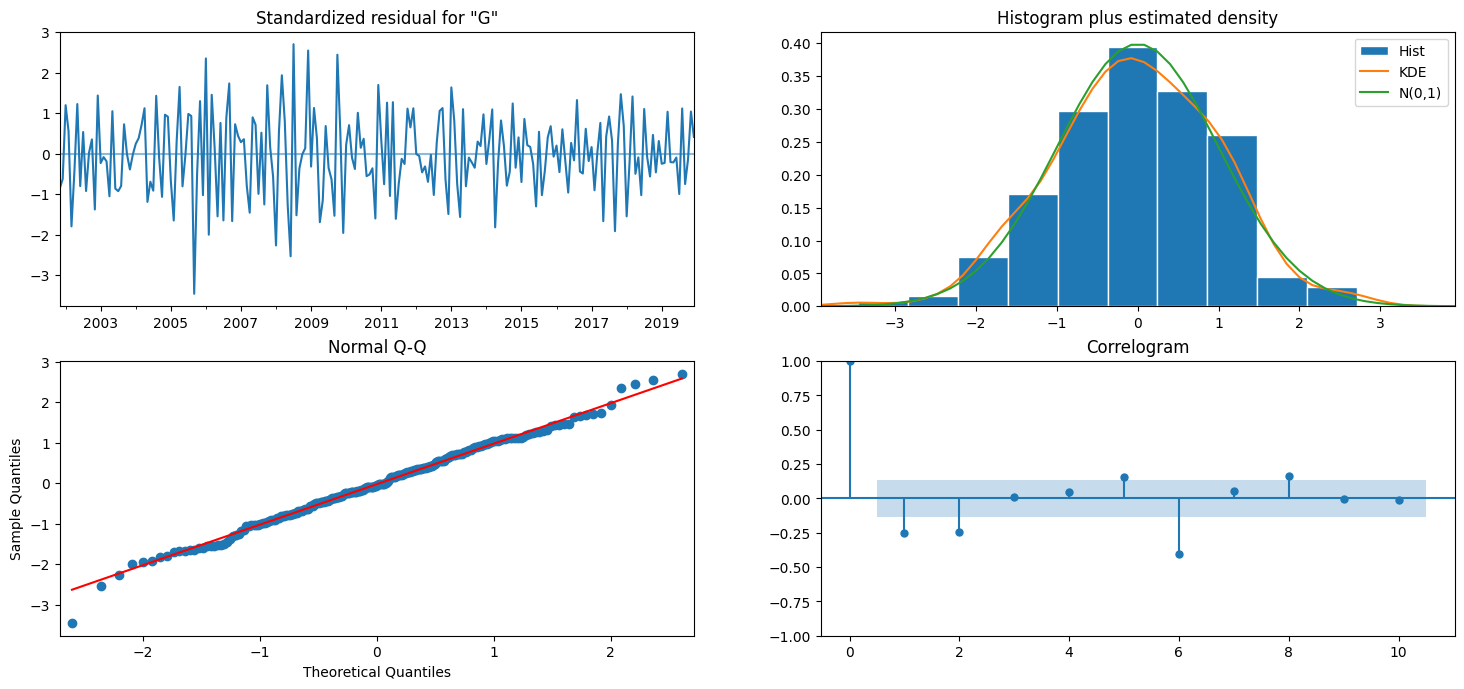

In [610]:
resultado_superior_121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [611]:
model_superior_221 = SARIMAX(
  train_superior_log,
  order=(2,2,1),
  seasonal_order=(seasonalOrderSuperior,1,0,diffToUse),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_superior_221 = model_superior_221.fit(disp=False)
print(resultado_superior_221.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9352      0.060    -15.559      0.000      -1.053      -0.817
ar.L2         -0.3625      0.064     -5.646      0.000      -0.488      -0.237
ma.L1         -1.0000    192.092     -0.005      0.996    -377.494     375.494
sigma2         0.1120     21.518      0.005      0.996     -42.062      42.286


c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


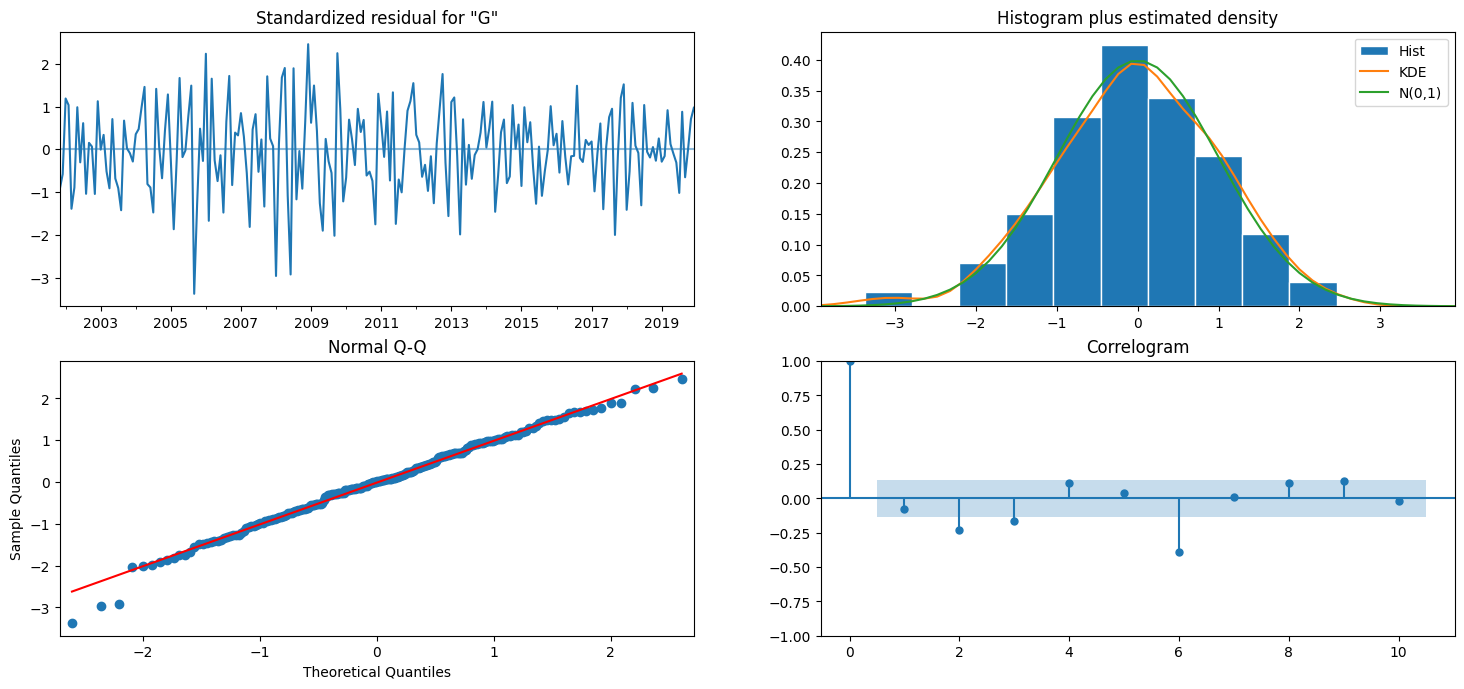

In [612]:
resultado_superior_221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [613]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_superior_121.aic)
print("Modelo 221=",resultado_superior_221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_superior_121.bic)
print("Modelo 221=",resultado_superior_221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= 183.98181841758426
Modelo 221= 154.8087396115251
Resultados de BIC (Bayesian information criterion)
Modelo 121= 194.13530360595152
Modelo 221= 168.34671986268148


De acuerdo a ambos indicadores es mejor el modelo p=1, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Diesel

In [614]:
seasonalOrderDiesel = 3
if (dfToUse == "importacion"):
  seasonalOrderSuperior = 0


model_diesel_121 = SARIMAX(
  train_diesel_log,
  order=(1,2,1),
  seasonal_order=(seasonalOrderDiesel,1,0,diffToUse),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_diesel_121 = model_diesel_121.fit()
print(resultado_diesel_121.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5498      0.064     -8.540      0.000      -0.676      -0.424
ma.L1         -1.0000    274.677     -0.004      0.997    -539.357     537.357
ar.S.L6       -0.7828      0.074    -10.632      0.000      -0.927      -0.638
ar.S.L12      -0.5093      0.094     -5.409      0.000      -0.694      -0.325
ar.S.L18      -0.3284      0.066     -4.956      0.000      -0.458      -0.199
sigma2         0.1213     33.317      0.004      0.997     -65.179      65.422


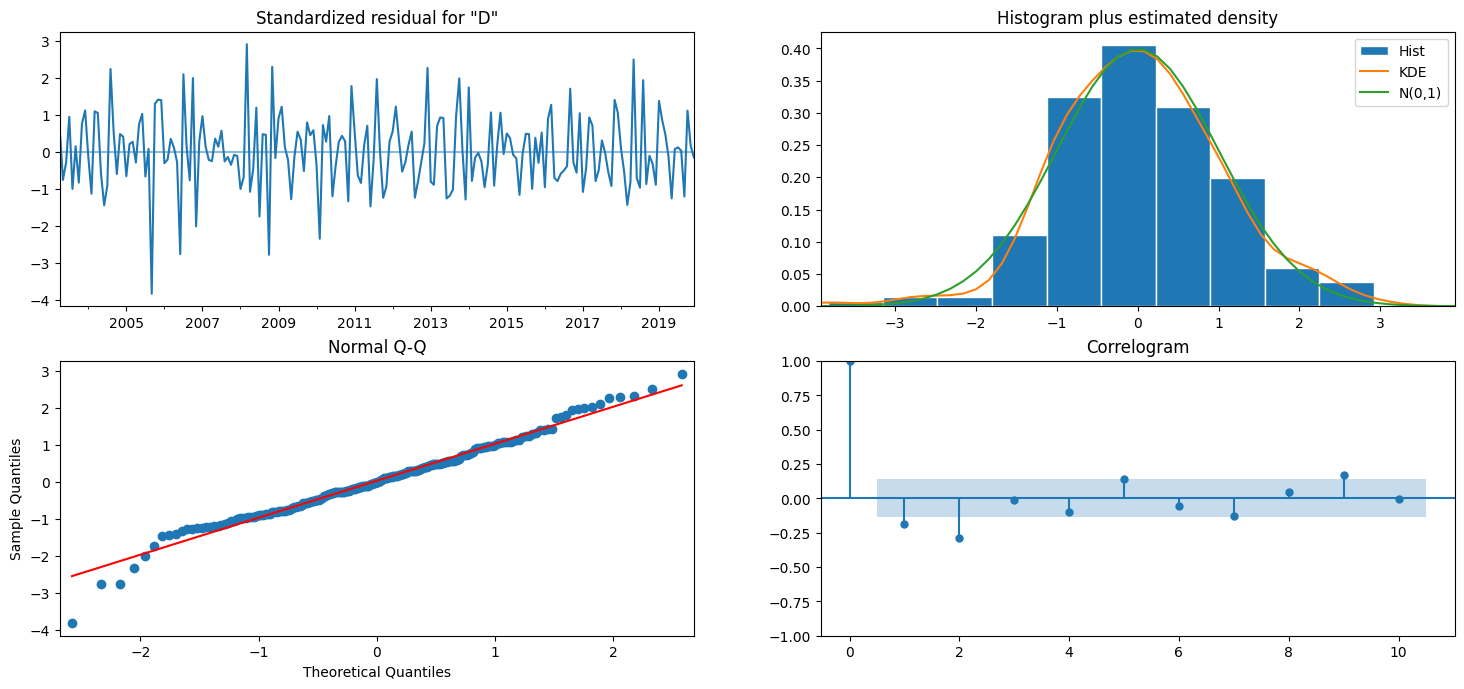

In [615]:
resultado_diesel_121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [616]:
model_diesel_221 = SARIMAX(
  train_diesel_log,
  order=(2,2,1),
  seasonal_order=(seasonalOrderDiesel,1,0,diffToUse),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_diesel_221 = model_diesel_221.fit(disp=False)
print(resultado_diesel_221.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7504      0.076     -9.914      0.000      -0.899      -0.602
ar.L2         -0.3471      0.061     -5.733      0.000      -0.466      -0.228
ma.L1         -1.0000    134.470     -0.007      0.994    -264.557     262.557
ar.S.L6       -0.8313      0.070    -11.940      0.000      -0.968      -0.695
ar.S.L12      -0.5770      0.083     -6.918      0.000      -0.741      -0.414
ar.S.L18      -0.3830      0.073     -5.222      0.000      -0.527      -0.239
sigma2         0.1075     14.457      0.007      0.994     -28.228      28.443


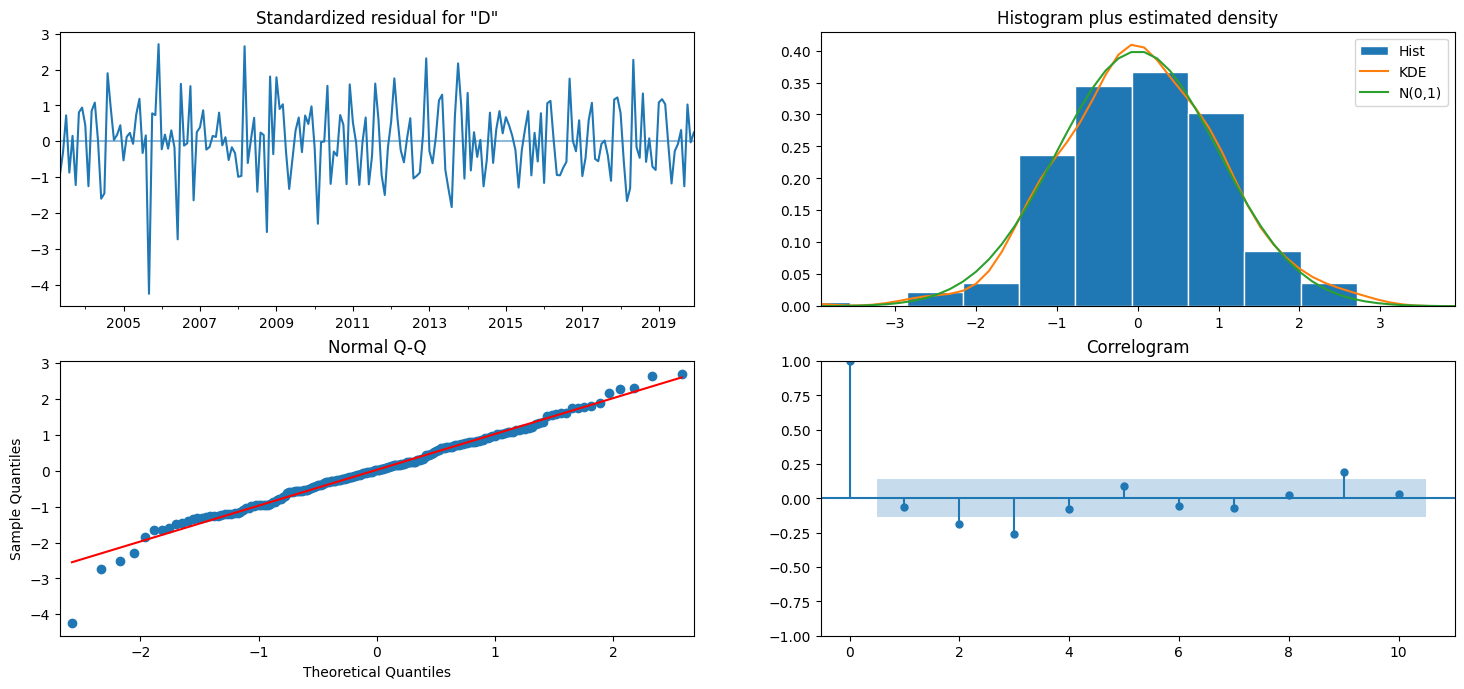

In [617]:
resultado_diesel_221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [618]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_diesel_121.aic)
print("Modelo 221=",resultado_diesel_221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_diesel_121.bic)
print("Modelo 221=",resultado_diesel_221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= 163.6089288435611
Modelo 221= 140.74704640015244
Resultados de BIC (Bayesian information criterion)
Modelo 121= 183.42875829191556
Modelo 221= 163.83526796598872


De acuerdo a ambos indicadores es mejor el modelo p=2, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Predicción con el mejor modelo

In [619]:
df_regular_indexed = df[['Fecha', label_regular]]
df_regular_indexed =  df_regular_indexed.set_index(['Fecha'])

In [620]:
df_superior_indexed = df[['Fecha', label_super]]
df_superior_indexed =  df_superior_indexed.set_index(['Fecha'])

In [621]:
df_diesel_indexed = df[['Fecha', label_diesel]]
df_diesel_indexed =  df_diesel_indexed.set_index(['Fecha'])

In [622]:
def checkModel(prediction, test_indexed, label):
  pred = prediction.get_prediction(
    start=test_indexed.index[0],
    end=test_indexed.index[-1],
  ).summary_frame(alpha=0.05)

  fig, ax = plt.subplots(figsize=(15,5))
  test_log = np.log(test_indexed[label])
  ax = test_log.plot(label='Test Data')
  ax.set(
      title='True and Predicted Values, with Confidence Intervals',
      xlabel='Date',
      ylabel='Actual / Predicted Values'
  )

  pred['mean'].plot(ax=ax, style='r', label='Predicted Mean')
  ax.fill_between(
      pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'],
      color='r', alpha=0.1
  )
  legend = ax.legend(loc='upper left')
  plt.show()

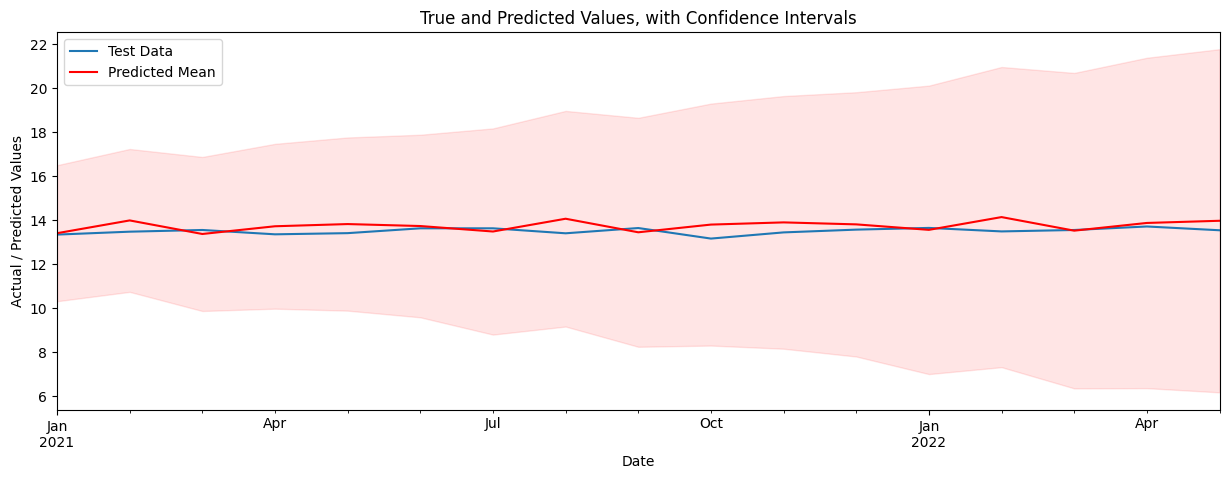

In [623]:
if (dfToUse == 'importacion'):
    checkModel(resultado_regular_221, test_regular_indexed, label_regular)
else:
    checkModel(resultado_regular_121, test_regular_indexed, label_regular)

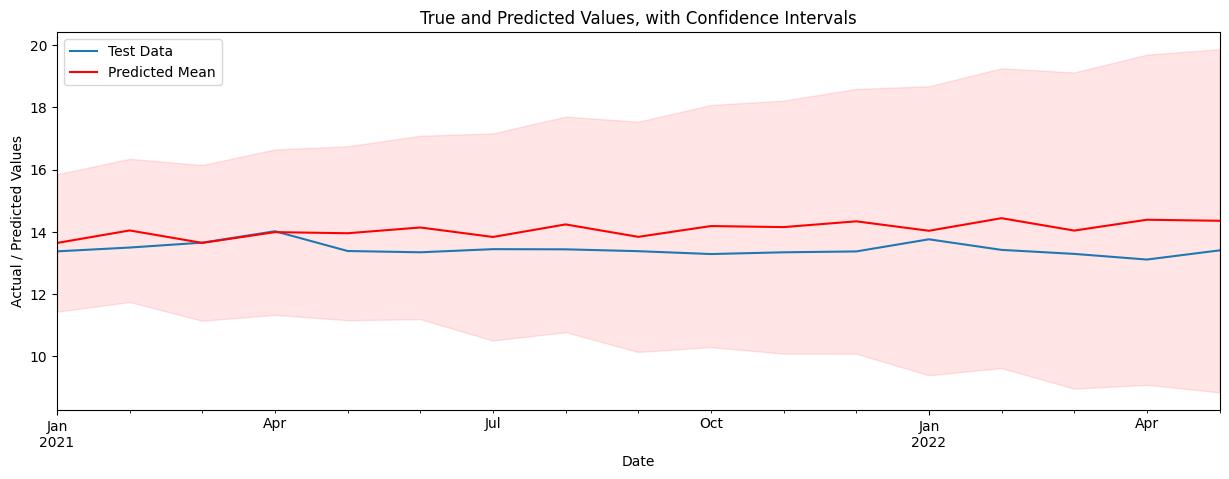

In [624]:
checkModel(resultado_superior_221, test_superior_indexed, label_super)

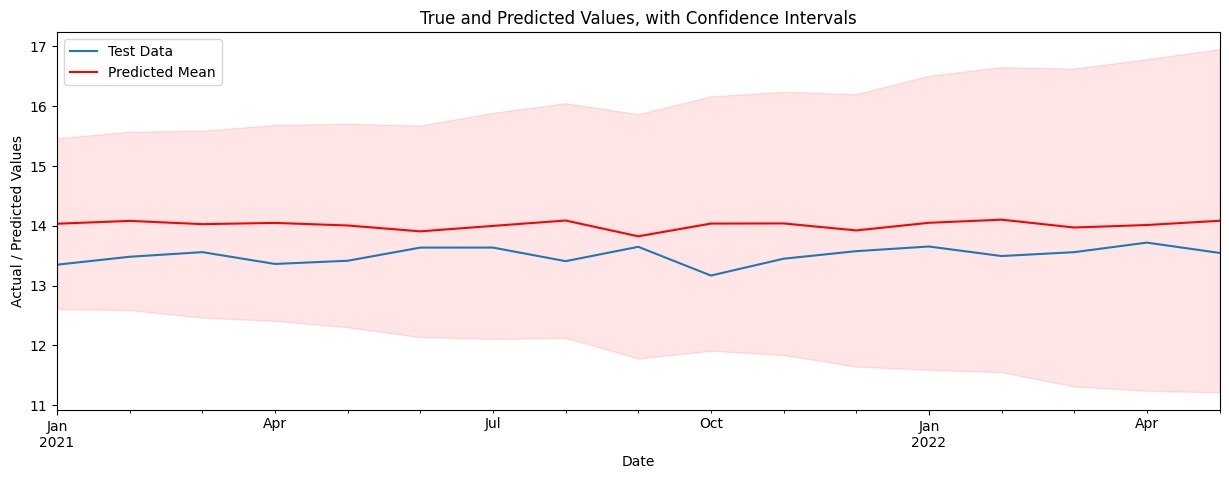

In [625]:
if (dfToUse == 'importacion'):
    checkModel(resultado_diesel_221, test_regular_indexed, label_regular)
else:
    checkModel(resultado_diesel_121, test_diesel_indexed, label_diesel)